<a href="https://colab.research.google.com/github/patarruda/if697_acidentesPRF/blob/main/ICD%20-%20Projeto%2001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJETO 01 [IF697 - Introdução Ciência de Dados. 2024.1]


**Aluna: Patrícia Arcelo de Arruda (paa3)**

---

ORIENTAÇÕES:
1. Coletar dados
2.	Realizar pré-processamento	dos	dados
  - Definição	de	tipos
  - Tratamento	de	dados	ausentes
  - Normalização	e	discretização
  - Limpeza	de	dados	(univariado,	bivariado	e	multivariado)
3.	Apresentar estatísticas descritivas	dos	dados
com	visualizações
4.	Realizar teste	de	hipóteses para comparação de	valores	de	categorias	(ex.	preço	m2 em diferentes bairros)	e	visualizar diferenças
- Bônus:
  - Integrar	dados	ou extrair	dados	da	Web
  - Utilizar técnicas não cobertas nas aulas

# CONFIGURAÇÕES INICIAIS

In [1]:
# instalação de dependências
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=f01586e41d077652ec7bfcdf6c1b7740c25bec4b1315850c6a91adc66101723b
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=b1d50311fe83154065908e53128a85be62f799f5e55024418ba9ad47f384c9fc
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [2]:
#imports
import numpy as np
import pandas as pd
from google.colab import drive
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import boxcox, shapiro
from numpy import log10, abs
from sklearn.cluster import DBSCAN

In [3]:
# Opcional (para salvar checkpoints)
# Google Drive: Set path do Google Drive para pasta dos datasets
drive.mount('/content/drive')
pathDrive = "/content/drive/MyDrive/ICD/data/"

Mounted at /content/drive


In [139]:
# Set path do github
pathGit = "https://raw.githubusercontent.com/patarruda/if697_acidentesPRF/main/data/"

In [4]:
# Funções auxiliares

# Converter string de numérico para float
def str_to_float(valor):
  return float(valor.replace(',', '.'))

# Contabilizar radares em um range
def count_radares(uf, br, km, range):
  return len(radares[(radares['UF'] == uf) & (radares['Rodovia'] == br) & (radares['Km'] >= km - range) & (radares['Km'] <= km + range)])

# converter string de horario para float
def hora_to_float(hora):
  return int(hora[0:2]) + int(hora[3:5])/60

# COLETA DE DADOS

## ACIDENTES EM RODOVIAS FEDERAIS - 2023

Dataset em arquivo .csv obtido no site de Dados Abertos da PRF e salvo no Drive do projeto.
> Vamos trabalhar com um subgrupo do dataset, selecionando apenas as ocorrências da região **NORDESTE**

> No pré-processamento serão acrescidas informações obtidas do dataset 'radares', para indicar quantitativo de radares nas proximidades do acidente.

Disponível em: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf

In [143]:
# Carregando dataset de acidentes (PRF)
  # encoding 'latin1' para suportar dados com acentuação
  # separador ';'
  # dtype 'br' setado como 'str' (evitar conversão automática para float)
ocorrencias = pd.read_csv(pathGit + "datatran2023.csv", encoding='latin1', sep=';', dtype={'br':str})

pd.set_option('display.max_columns', None)
display(ocorrencias.head())
print(ocorrencias.shape)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,496519,2023-01-01,domingo,02:00:00,ES,101,114,SOORETAMA,Ausência de reação do condutor,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,0,1,1,"-19,09484877","-40,05095848",SPRF-ES,DEL04-ES,UOP01-DEL04-ES
1,496543,2023-01-01,domingo,03:40:00,SP,116,"113,1",TAUBATE,Entrada inopinada do pedestre,Atropelamento de Pedestre,Com Vítimas Fatais,Plena Noite,Decrescente,Céu Claro,Dupla,Reta,Sim,5,1,0,0,0,4,0,2,"-23,0445658","-45,58259814",SPRF-SP,DEL02-SP,UOP02-DEL02-SP
2,496590,2023-01-01,domingo,01:40:00,MT,163,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,Tombamento,Com Vítimas Feridas,Plena Noite,Crescente,Ignorado,Simples,Curva;Declive,Não,1,0,0,1,0,0,1,1,"-9,70020602","-54,87588757",SPRF-MT,DEL06-MT,UOP03-DEL06-MT
3,496610,2023-01-01,domingo,10:40:00,PR,376,"314,8",ORTIGUEIRA,Velocidade Incompatível,Tombamento,Sem Vítimas,Pleno dia,Crescente,Sol,Dupla,Curva,Não,1,0,0,0,1,0,0,1,"-23,985512","-51,083555",SPRF-PR,DEL07-PR,UOP02-DEL07-PR
4,496659,2023-01-01,domingo,14:55:00,MG,116,"569,4",MANHUACU,Acumulo de água sobre o pavimento,Colisão frontal,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Simples,Declive;Curva,Não,3,0,0,2,1,0,2,2,"-20,10007457","-42,17884091",SPRF-MG,DEL06-MG,UOP03-DEL06-MG


(67723, 30)


In [6]:
# Ocorrências do Nordeste
nordeste = ['PE','PB','AL','SE','BA','RN','CE','PI','MA']
ocorrencias = ocorrencias[ocorrencias['uf'].isin(nordeste)].reset_index(drop=True)
display(ocorrencias.head())
print(ocorrencias.shape)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,496711,2023-01-01,domingo,21:50:00,BA,116,366,SERRINHA,Velocidade Incompatível,Colisão traseira,Sem Vítimas,Plena Noite,Decrescente,Garoa/Chuvisco,Simples,Reta,Não,2,0,0,0,2,0,0,2,"-11,72514","-38,98642914",SPRF-BA,DEL02-BA,UOP01-DEL02-BA
1,496780,2023-01-02,segunda-feira,09:00:00,PI,316,"7,7",TERESINA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Decrescente,Sol,Múltipla,Reta,Sim,3,0,2,0,1,0,2,2,"-5,15584638","-42,77173332",SPRF-PI,DEL01-PI,UOP02-DEL01-PI
2,496787,2023-01-02,segunda-feira,10:15:00,PE,101,68,RECIFE,Ausência de reação do condutor,Engavetamento,Com Vítimas Feridas,Pleno dia,Decrescente,Nublado,Simples,Viaduto,Sim,5,0,2,0,3,0,2,3,"-8,05074296","-34,94580619",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
3,496827,2023-01-02,segunda-feira,13:24:00,PE,101,57,PAULISTA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Nublado,Dupla,Curva,Não,3,0,1,0,1,1,1,2,"-7,96346213","-34,91513486",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
4,496859,2023-01-02,segunda-feira,12:30:00,MA,316,"615,7",TIMON,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,0,1,0,1,2,"-5,086548","-42,837265",SPRF-MA,DEL03-MA,UOP02-DEL03-MA


(14632, 30)


In [7]:
# Verificando Index
ocorrencias.index

RangeIndex(start=0, stop=14632, step=1)

## RADARES DNIT

Dados disponíveis em site do DNIT, coletados via **"Web Scraping" em Python**, utilizando as bibliotecas *selenium* e *BeautifulSoup*.

> Devido a incompatibilidade do Colab para rodar webdriver do selenium com a página fonte (webapp em VUE), **desenvolvemos e executamos nosso script localmente** e salvamos no Drive do Projeto o arquivo .csv gerado.

Dados disponíveis em: https://servicos.dnit.gov.br/multas/informacoes/equipamentos-fiscalizacao

Script **radares_scrapTable.py**: https://raw.githubusercontent.com/patarruda/if697_acidentesPRF/main/radares_scrapTable.py

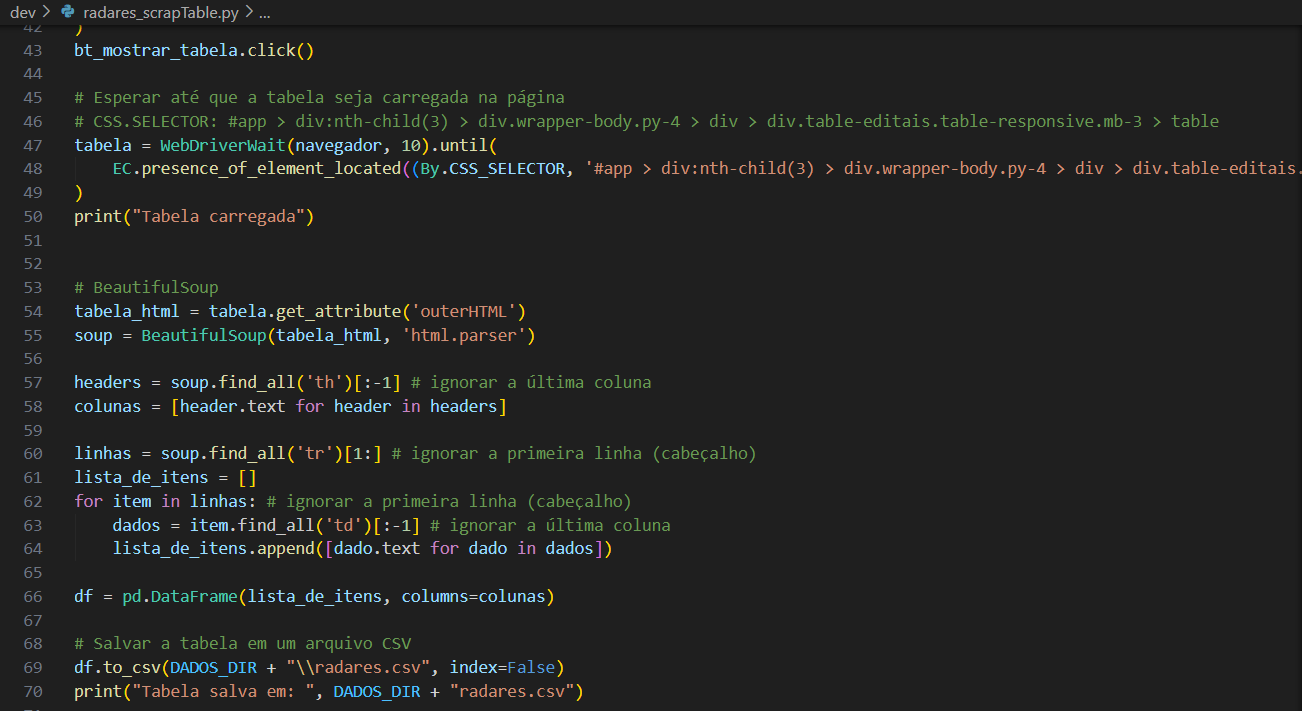

In [142]:
# Carregando dataset de radares (DNIT)
  # encoding 'utf-8' para suportar dados com acentuação
  # separador ','
  # dtype 'Rodovia' setado como 'str' (evitar conversão automática para float)
radares = pd.read_csv(pathGit + "radaresDNIT.csv", encoding='utf-8', sep=',', dtype={'Rodovia':str})

pd.set_option('display.max_columns', None)
display(radares.head())
print(radares.shape)

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
0,ROB20040023,Redutor Eletrônico de Velocidade,RO,PORTO VELHO,364,"712,585","-63.87748, -8.77459",12908470,FLICD2005A00558
1,ROR20040020,Controlador Eletrônico de Velocidade,RO,PORTO VELHO,364,"714,250","-63.889707, -8.777642",12908471,FLISD2005A00554
2,ROB20040024,Redutor Eletrônico de Velocidade,RO,PORTO VELHO,364,"800,680","-64.404046, -9.258233",4781728,FLICD2005A00555
3,ROB21120033,Redutor Eletrônico de Velocidade,RO,PORTO VELHO,319,"61,065","-63.889548, -8.741321",14826018,FLICD2106A00572
4,ROR20050023,Controlador Eletrônico de Velocidade,RO,PORTO VELHO,364,"703,380","-63.803277, -8.800411",12908465,FLISD2005A00529


(1795, 9)


# PRÉ-PROCESSAMENTO

## Dataset 'radares'

> O pré-processamento do dataset '`radares`' é simplificado, para posteriormente se obter a informação sobre quantitativo de radares nas proximidades de cada acidente e incluí-la no dataset 'ocorrencias'.

- Checagem de dados nulos
- Tipagem dos dados
- Formatação dos campos 'Rodovia' e 'Km'
- Outliers: Eliminação de duplicatas e dados irrelevantes

In [9]:
# Verificação de instâncias nulas
radares.isnull().sum()

Código do Equipamento    0
Equipamento              0
UF                       0
Município                0
Rodovia                  0
Km                       0
Coordenadas              0
Registro INMETRO         0
Nº de Série              0
dtype: int64

In [10]:
# Tipos dos dados
radares.dtypes

Código do Equipamento    object
Equipamento              object
UF                       object
Município                object
Rodovia                  object
Km                       object
Coordenadas              object
Registro INMETRO         object
Nº de Série              object
dtype: object

In [11]:
# Verificando formatação das BRs
print(f"BRs com formatação incorreta: {len(radares[radares['Rodovia'].apply(len) < 3])}\n")

# converter coluna KM para float
radares['Km'] = radares['Km'].apply(str_to_float)

# resumo
radares.info()

BRs com formatação incorreta: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Código do Equipamento  1795 non-null   object 
 1   Equipamento            1795 non-null   object 
 2   UF                     1795 non-null   object 
 3   Município              1795 non-null   object 
 4   Rodovia                1795 non-null   object 
 5   Km                     1795 non-null   float64
 6   Coordenadas            1795 non-null   object 
 7   Registro INMETRO       1795 non-null   object 
 8   Nº de Série            1795 non-null   object 
dtypes: float64(1), object(8)
memory usage: 126.3+ KB


###**Outliers**

- Duplicatas

Vamos considerar que são duplicatas as instâncias com mesma 'Coordenadas' ou com mesma ['UF', 'Rodovia' e 'Km'].
Normalmente uma mesma estrutura da radar monitora várias faixas e sentidos da via. Nos registros do DNIT, cada faixa/sentido monitorado em determinado ponto, consta como se fosse um equipamento independente, quando na verdade todo o conjunto se trata de uma estrutura única.

In [12]:
# quantidade de instâncias
len(radares)

1795

In [13]:
# Duplicatas (segundo 'Coordenadas')
radares[radares.duplicated(subset=['Coordenadas'], keep=False)]

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
76,PBB18120030,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,444.950,"-38.07558, -6.78689",14363789,FSC110-0332
77,PBB18120031,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,444.950,"-38.07558, -6.78689",14363790,FSC110-0333
78,PBB18120024,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.950,"-38.085274, -6.785988",14363791,FSC110-0328
79,PBB18120025,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.950,"-38.085274, -6.785988",14363792,FSC110-0329
80,PBB18120026,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.450,"-38.08063, -6.787037",14363787,FSC110-0330
...,...,...,...,...,...,...,...,...,...
1681,MSS19100006,Controlador Eletrônico Misto,MS,TRES LAGOAS,262,7.881,"-51.683427, -20.798855",FISCALTECH,FSCII-6772
1682,MSS19100007,Controlador Eletrônico Misto,MS,TRES LAGOAS,262,7.859,"-51.683427, -20.798855",FISCALTECH,FSCII-6774
1683,MSS19100008,Controlador Eletrônico Misto,MS,TRES LAGOAS,262,7.835,"-51.683427, -20.798855",FISCALTECH,FSCII-6773
1724,GOR22060038,Controlador Eletrônico de Velocidade,GO,MINEIROS,364,302.170,"-52.533325, -17.531144",13871423,FLISD2002A00449


In [14]:
# Eliminando duplicatas
radares.drop_duplicates(subset =['Coordenadas'], keep = False, inplace = True)
radares.drop_duplicates(subset =['UF', 'Rodovia', 'Km'], keep = False, inplace = True)
radares.reset_index(drop= True, inplace= True)
print(f"Radares: {len(radares)}")   # Tamanho após eliminação
radares.tail()

Radares: 1581


,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
1576,MTB19090006,Redutor Eletrônico de Velocidade,MT,PRIMAVERA DO LESTE,070,281.070,"-54.305769, -15.5674",13971739,11099
1577,MTB19090007,Redutor Eletrônico de Velocidade,MT,PRIMAVERA DO LESTE,070,282.435,"-54.317054, -15.573105",13971737,11069
1578,MTB19100035,Redutor Eletrônico de Velocidade,MT,PRIMAVERA DO LESTE,070,284.300,"-54.333267, -15.574498",13971770,11024
1579,SCB20110124,Redutor Eletrônico de Velocidade,SC,APIUNA,470,99.140,"-49.39638, -27.041602",14794085,6068
1580,SCB20100121,Redutor Eletrônico de Velocidade,SC,APIUNA,470,97.440,"-49.38398, -27.031218",14743398,6066


In [15]:
# Verificar se há codigos de equipamentos duplicados
radares[radares.duplicated(subset=['Código do Equipamento'], keep=False)]

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série


Para calcular os radares nas proximidades dos acidentes, vamos precisar dos campos 'UF', 'Rodovia' e 'Km'. Vamos manter também o campo 'Código do Equipamento' para identificação.

In [16]:
# Eliminar colunas irrelevantes
radares.drop(['Equipamento', 'Município', 'Registro INMETRO', 'Nº de Série', 'Coordenadas'], axis=1, inplace=True)
radares.tail()

,Código do Equipamento,UF,Rodovia,Km
1576,MTB19090006,MT,070,281.070
1577,MTB19090007,MT,070,282.435
1578,MTB19100035,MT,070,284.300
1579,SCB20110124,SC,470,99.140
1580,SCB20100121,SC,470,97.440


In [17]:
# Index
radares.index

RangeIndex(start=0, stop=1581, step=1)

<Axes: >

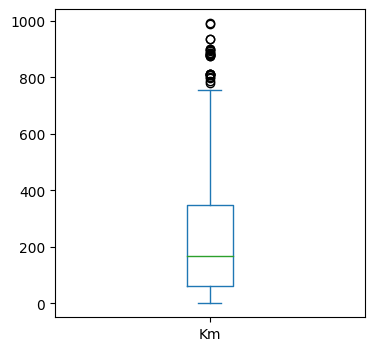

In [18]:
# Vizualizar boxplot
radares['Km'].plot(kind='box', figsize=(4,4))

<Axes: >

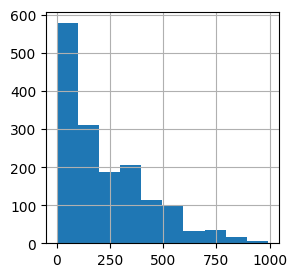

In [19]:
# Verificar distruibuição
radares['Km'].hist(figsize=(3,3))

Como a distribuição do atribudo está com uma alta concentração inicial, vamos converter os valores para escala logarítimica para obter uma distribuição de melhor visualização.

<Axes: >

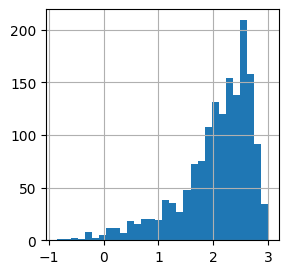

In [20]:
# Transformando para escala logaritmica
radares['km_log'] = log10(radares['Km'])
radares['km_log'].hist(figsize=(3,3), bins=30)

A distribuição de 'km_log' aparenta ser assimétrica, com concentração à direta.

In [21]:
# Calcular MAD usando scipy.stats, com fator b = 0.6745 (estimador não-enviesado do desvio padrão)
mad = stats.median_abs_deviation(radares['km_log'], scale=0.6745) # == abs(radares['km_log'] - radares['km_log'].median()).median()*(1/0.6745)
print(mad)

0.5373055431228954


<Axes: ylabel='Frequency'>

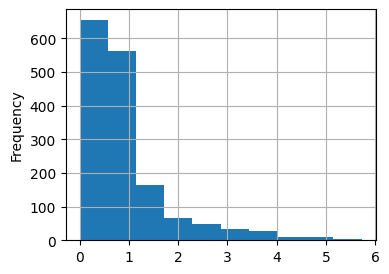

In [22]:
# Calcular z-scores robusto
z_robust = abs((radares['km_log'] - radares['km_log'].median())/mad)

# Visualizar distribuição dos scores
z_robust.plot(kind='hist', figsize=(4,3), grid='True')

In [23]:
# Candidatos a outliers (optamos por limiar de 5)
radares[z_robust > 5]

,Código do Equipamento,UF,Rodovia,Km,km_log
1393,RSB20010199,RS,116,0.240,-0.619789
1410,MTB23030070,MT,174,0.331,-0.480172
1418,MTB20040048,MT,364,0.140,-0.853872
1419,MTB20040049,MT,364,0.260,-0.585027


## Dataset 'ocorrencias'

> O pré-processamento do dataset 'ocorrencias' é mais aprofundado, envolvendo mais procedimentos.

- Tratamento de instâncias nulas e dados faltantes (eliminação/imputação de valores)
- Tipagem dos dados
- Ajuste/criação de colunas
- Agregamento de informações de radares
- Normalização
- Discretização
- Outliers


### Instâncias nulas

 - BRs: Serão removidas as instâncias com BRs nulas, pois são acidentes fora de rodovias federais, não incluídos no escopo do estudo.

In [24]:
# Quantidade de instâncias nulas
ocorrencias.isnull().sum()

id                         0
data_inversa               0
dia_semana                 0
horario                    0
uf                         0
br                        34
km                        34
municipio                  0
causa_acidente             0
tipo_acidente              0
classificacao_acidente     0
fase_dia                   0
sentido_via                0
condicao_metereologica     0
tipo_pista                 0
tracado_via                0
uso_solo                   0
pessoas                    0
mortos                     0
feridos_leves              0
feridos_graves             0
ilesos                     0
ignorados                  0
feridos                    0
veiculos                   0
latitude                   0
longitude                  0
regional                   0
delegacia                  4
uop                        9
dtype: int64

In [25]:
# Eliminando instâncias nulas (BRs)
ocorrencias.dropna(subset='br', inplace=True)

# Resultado: sem instâncias nulas no dataframe
ocorrencias.isnull().sum()

id                        0
data_inversa              0
dia_semana                0
horario                   0
uf                        0
br                        0
km                        0
municipio                 0
causa_acidente            0
tipo_acidente             0
classificacao_acidente    0
fase_dia                  0
sentido_via               0
condicao_metereologica    0
tipo_pista                0
tracado_via               0
uso_solo                  0
pessoas                   0
mortos                    0
feridos_leves             0
feridos_graves            0
ilesos                    0
ignorados                 0
feridos                   0
veiculos                  0
latitude                  0
longitude                 0
regional                  0
delegacia                 0
uop                       0
dtype: int64

In [26]:
# Resetar os índices
ocorrencias.reset_index(drop=True, inplace=True)
ocorrencias.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,496711,2023-01-01,domingo,21:50:00,BA,116,366,SERRINHA,Velocidade Incompatível,Colisão traseira,Sem Vítimas,Plena Noite,Decrescente,Garoa/Chuvisco,Simples,Reta,Não,2,0,0,0,2,0,0,2,"-11,72514","-38,98642914",SPRF-BA,DEL02-BA,UOP01-DEL02-BA
1,496780,2023-01-02,segunda-feira,09:00:00,PI,316,"7,7",TERESINA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Decrescente,Sol,Múltipla,Reta,Sim,3,0,2,0,1,0,2,2,"-5,15584638","-42,77173332",SPRF-PI,DEL01-PI,UOP02-DEL01-PI
2,496787,2023-01-02,segunda-feira,10:15:00,PE,101,68,RECIFE,Ausência de reação do condutor,Engavetamento,Com Vítimas Feridas,Pleno dia,Decrescente,Nublado,Simples,Viaduto,Sim,5,0,2,0,3,0,2,3,"-8,05074296","-34,94580619",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
3,496827,2023-01-02,segunda-feira,13:24:00,PE,101,57,PAULISTA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Nublado,Dupla,Curva,Não,3,0,1,0,1,1,1,2,"-7,96346213","-34,91513486",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
4,496859,2023-01-02,segunda-feira,12:30:00,MA,316,"615,7",TIMON,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,0,1,0,1,2,"-5,086548","-42,837265",SPRF-MA,DEL03-MA,UOP02-DEL03-MA


In [27]:
# Checando indice
ocorrencias.index

RangeIndex(start=0, stop=14598, step=1)

### Tipagem dos dados e ajustes de colunas

- BRs: Correção para o formato "###"

- Data e Hora: Colunas reajustadas, criação de novos atributos temporais (ano, mes)

- Tipos categóricos e numéricos: Ajustados.

In [28]:
# Verificar tipos dos dados
ocorrencias.dtypes

id                         int64
data_inversa              object
dia_semana                object
horario                   object
uf                        object
br                        object
km                        object
municipio                 object
causa_acidente            object
tipo_acidente             object
classificacao_acidente    object
fase_dia                  object
sentido_via               object
condicao_metereologica    object
tipo_pista                object
tracado_via               object
uso_solo                  object
pessoas                    int64
mortos                     int64
feridos_leves              int64
feridos_graves             int64
ilesos                     int64
ignorados                  int64
feridos                    int64
veiculos                   int64
latitude                  object
longitude                 object
regional                  object
delegacia                 object
uop                       object
dtype: obj

In [29]:
# Verificando formatação das BRs (Formato correto: '###')
print(f"BRs com formatação incorreta: {len(ocorrencias[ocorrencias['br'].apply(len) < 3])}")

BRs com formatação incorreta: 530


In [30]:
# Corrigindo formatação das BRs
ocorrencias['br'] = ocorrencias['br'].apply(lambda br: br.zfill(3)) # preencher com zeros à esquerda, até string ficar com 3 caracteres
print(f"BRs com formatação incorreta: {len(ocorrencias[ocorrencias['br'].apply(len) != 3])}")

BRs com formatação incorreta: 0


In [31]:
# Conversão de tipos

# Categóricos
categoricos = ['dia_semana', 'uf', 'br', 'municipio', 'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via',
               'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'regional', 'delegacia', 'uop']
ocorrencias[categoricos] = ocorrencias[categoricos].astype('category')

# Numéricos (com conversão de string para float)
ocorrencias[['km', 'latitude', 'longitude']] = ocorrencias[['km', 'latitude', 'longitude']].applymap(str_to_float)

In [32]:
# Data/hora

# Nova coluna datetime
ocorrencias ['data_hora'] = pd.to_datetime(ocorrencias['data_inversa'] + " " + ocorrencias['horario'])

# Ano, mês, dia e hora (float)
ocorrencias['ano'] = ocorrencias['data_inversa'].str.slice(0, 4).astype('int')
ocorrencias['mes'] = ocorrencias['data_inversa'].str.slice(5, 7).astype('int')
ocorrencias['dia'] = ocorrencias['data_inversa'].str.slice(8, 10).astype('int')
ocorrencias['hora'] = ocorrencias['horario'].apply(hora_to_float)

# Descartar
ocorrencias.drop(['data_inversa', 'horario'], axis=1, inplace=True)

# Reordenar colunas
ocorrencias = ocorrencias[['data_hora', 'ano', 'mes', 'dia', 'hora'] + list(ocorrencias.columns)[0:-5]]

ocorrencias.tail()

,data_hora,ano,mes,dia,hora,id,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
14593,2023-11-08 19:40:00,2023,11,8,19.666667,587015,quarta-feira,BA,324,437.0,RIACHAO DO JACUIPE,Pedestre cruzava a pista fora da faixa,Atropelamento de Pedestre,Com Vítimas Feridas,Plena Noite,Crescente,Ignorado,Simples,Reta,Sim,2,0,0,1,0,1,1,2,-11.801755,-39.398370,SPRF-BA,DEL04-BA,UOP02-DEL04-BA
14594,2023-12-18 19:00:00,2023,12,18,19.000000,587357,segunda-feira,PI,343,33.0,PARNAIBA,Mal súbito do condutor,Queda de ocupante de veículo,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Simples,Interseção de Vias;Reta,Não,1,0,0,1,0,0,1,1,-3.097037,-41.780117,SPRF-PI,DEL05-PI,UOP01-DEL05-PI
14595,2023-09-06 17:15:00,2023,9,6,17.250000,587377,quarta-feira,BA,101,876.0,TEIXEIRA DE FREITAS,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Anoitecer,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,1,0,0,2,2,-17.538061,-39.714371,SPRF-BA,DEL09-BA,UOP02-DEL09-BA
14596,2023-12-08 09:58:00,2023,12,8,9.966667,588285,sexta-feira,MA,316,29.0,PRESIDENTE MEDICI,Reação tardia ou ineficiente do condutor,Capotamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,0,1,1,-2.322658,-45.835350,SPRF-MA,DEL02-MA,UOP02-DEL02-MA
14597,2023-08-21 15:30:00,2023,8,21,15.500000,588731,segunda-feira,BA,110,369.0,CATU,Condutor deixou de manter distância do veículo...,Queda de ocupante de veículo,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,0,1,1,0,1,2,-12.377890,-38.383670,SPRF-BA,DEL01-BA,UOP04-DEL01-BA


In [33]:
# Resumo dos dados pós conversões
ocorrencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14598 entries, 0 to 14597
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   data_hora               14598 non-null  datetime64[ns]
 1   ano                     14598 non-null  int64         
 2   mes                     14598 non-null  int64         
 3   dia                     14598 non-null  int64         
 4   hora                    14598 non-null  float64       
 5   id                      14598 non-null  int64         
 6   dia_semana              14598 non-null  category      
 7   uf                      14598 non-null  category      
 8   br                      14598 non-null  category      
 9   km                      14598 non-null  float64       
 10  municipio               14598 non-null  category      
 11  causa_acidente          14598 non-null  category      
 12  tipo_acidente           14598 non-null  catego

In [34]:
# estatísticas básicas
ocorrencias.describe()

,data_hora,ano,mes,dia,hora,id,km,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude
count,14598,14598.0,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000,14598.000000
mean,2023-07-09 15:49:33.247020032,2023.0,6.762502,15.630086,13.432149,535681.388957,216.120195,2.457802,0.117071,0.828470,0.348883,0.975202,0.188176,1.177353,1.777778,-8.457497,-38.656241
min,2023-01-01 00:20:00,2023.0,1.000000,1.000000,0.000000,496513.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-18.168402,-47.558980
25%,2023-04-10 17:25:00,2023.0,4.000000,8.000000,8.420833,516844.000000,48.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-10.906400,-40.420099
50%,2023-07-10 15:43:30,2023.0,7.000000,16.000000,14.166667,535976.000000,118.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,-7.994397,-38.479949
75%,2023-10-09 09:00:00,2023.0,10.000000,23.000000,18.466667,554792.250000,332.075000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,-5.828471,-35.831652
max,2023-12-31 23:15:00,2023.0,12.000000,31.000000,23.966667,588858.000000,1056.400000,51.000000,7.000000,31.000000,7.000000,51.000000,6.000000,38.000000,13.000000,-1.782009,-34.828400
std,NaN,0.0,3.450484,8.763697,5.943963,22010.199057,225.547563,1.946491,0.381181,1.066485,0.650258,1.607192,0.455612,1.189281,0.706361,3.467238,3.211296


### Duplicatas e dados irrelevantes (Outliers)

Consideramos duplicatas ocorrências que tenham o mesmo 'id' no banco de dados, ou que apresentem identidade de alguns atributos chave, indicando se tratarem de registros realizados em duplicidade: `'data_hora', 'uf', 'br', 'km', 'causa_acidente', 'tipo_acidente', 'pessoas', 'veiculos'`

In [35]:
# IDs únicos (verificar se há registros duplicados no banco de dados)
print(f"IDs únicos? {ocorrencias['id'].nunique() == len(ocorrencias['id'])}")

IDs únicos? True


In [36]:
# Acidentes registrados em duplicidade
ocorrencias[ocorrencias.duplicated(subset=['data_hora', 'uf', 'br', 'km', 'causa_acidente', 'tipo_acidente', 'pessoas', 'veiculos'], keep=False)]

,data_hora,ano,mes,dia,hora,id,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
3621,2023-11-03 19:40:00,2023,11,3,19.666667,584549,sexta-feira,BA,101,841.9,TEIXEIRA DE FREITAS,Ausência de reação do condutor,Tombamento,Com Vítimas Feridas,Plena Noite,Decrescente,Céu Claro,Simples,Curva;Declive,Não,1,0,1,0,0,0,1,1,-17.444788,-39.693388,SPRF-BA,DEL09-BA,UOP02-DEL09-BA
3622,2023-11-03 19:40:00,2023,11,3,19.666667,584961,sexta-feira,BA,101,841.9,TEIXEIRA DE FREITAS,Ausência de reação do condutor,Tombamento,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Declive;Reta,Não,1,0,0,0,1,0,0,1,-17.444788,-39.693388,SPRF-BA,DEL09-BA,UOP02-DEL09-BA
10942,2023-09-11 06:25:00,2023,9,11,6.416667,547976,segunda-feira,BA,324,530.0,FEIRA DE SANTANA,Acumulo de óleo sobre o pavimento,Colisão com objeto,Sem Vítimas,Amanhecer,Decrescente,Chuva,Dupla,Curva,Não,1,0,0,0,1,0,0,1,-12.328185,-38.861742,SPRF-BA,DEL01-BA,UOP03-DEL01-BA
10969,2023-09-11 06:25:00,2023,9,11,6.416667,548168,segunda-feira,BA,324,530.0,FEIRA DE SANTANA,Acumulo de óleo sobre o pavimento,Colisão com objeto,Sem Vítimas,Amanhecer,Decrescente,Chuva,Dupla,Curva,Não,1,0,0,0,1,0,0,1,-12.328185,-38.861742,SPRF-BA,DEL01-BA,UOP03-DEL01-BA
12270,2023-10-26 17:15:00,2023,10,26,17.250000,557347,quinta-feira,PB,101,88.5,JOAO PESSOA,Reação tardia ou ineficiente do condutor,Tombamento,Com Vítimas Feridas,Anoitecer,Decrescente,Chuva,Dupla,Reta,Sim,1,0,1,0,0,0,1,1,-7.164700,-34.899936,SPRF-PB,DEL01-PB,UOP02-DEL01-PB
12271,2023-10-26 17:15:00,2023,10,26,17.250000,557349,quinta-feira,PB,101,88.5,JOAO PESSOA,Reação tardia ou ineficiente do condutor,Tombamento,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Dupla,Reta,Sim,1,0,1,0,0,0,1,1,-7.164700,-34.899936,SPRF-PB,DEL01-PB,UOP02-DEL01-PB


In [37]:
# Eliminar duplicatas
ocorrencias.drop_duplicates(subset=['data_hora', 'uf', 'br', 'km', 'causa_acidente', 'tipo_acidente', 'pessoas', 'veiculos'], keep=False, inplace=True)
ocorrencias.reset_index(drop=True, inplace=True)  # resetar index
ocorrencias[ocorrencias.duplicated(subset=['data_hora', 'uf', 'br', 'km', 'causa_acidente', 'tipo_acidente', 'pessoas', 'veiculos'], keep=False)] # Mostrar

,data_hora,ano,mes,dia,hora,id,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop


Consideramos desnecessários os seguintes atributos para as análises futuras:

- 'id': indexador do BD
- 'feridos': informação já destrinchada em 'feridos_leves' e 'feridos_graves'
- 'ignorados': envolvidos não identificados/sem condição de saúde conhecida após o acidente

In [38]:
# Excluir dados irrelevantes (colunas não utilizadas nas análises)
ocorrencias.drop(['id','feridos','ignorados'], axis=1, inplace=True)

### Discretização

- Hora: discretizado em 4 intervalos fixos referentes às faixas de horário da Madrugada, Manhã, Tarde e Noite.

- BR: discretizado em 4 intervalos estabelecidos conforme frequência dos dados, para cada combinação de 'uf' e 'br'.

In [39]:
# Distretizar 'hora' com 4 bins: cada um corresponderá a um período do dia (Madrugada, Manhã, Tarde e Noite)
ocorrencias['periodo_horario'] = pd.cut(ocorrencias['hora'], 4, labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'])

# Atualizar lista de categóricos
categoricos.append('periodo_horario')

# Contagem de instâncias por intervalo
ocorrencias['periodo_horario'].value_counts()

periodo_horario
Tarde        4405
Manhã        4265
Noite        4255
Madrugada    1667
Name: count, dtype: int64

In [40]:
# informações básicas
ocorrencias['periodo_horario'].describe()

count     14592
unique        4
top       Tarde
freq       4405
Name: periodo_horario, dtype: object

In [41]:
# Reordenar colunas
col = ocorrencias.columns
numCol = col.get_loc('hora')
ordem = col.tolist()
ordem.insert(numCol+1, 'periodo_horario')

ocorrencias = ocorrencias[ordem[:-1]]
print(ocorrencias.columns)

Index(['data_hora', 'ano', 'mes', 'dia', 'hora', 'periodo_horario',
       'dia_semana', 'uf', 'br', 'km', 'municipio', 'causa_acidente',
       'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'veiculos', 'latitude', 'longitude', 'regional', 'delegacia', 'uop'],
      dtype='object')


> Criaremos o atributo '`trecho_br`' a partir da discretização do campo '`br`'. Primeiro agruparemos os dados por '`uf`' e '`br`', para então criar os intervalos conforme **frequência dos dados (quantis)**.

In [42]:
# Discretizar 'km': 4 intervalos para cada combinação de 'uf' e 'br'
# intervalos com base na frequência dos dados (quantis)
   # duplicates='drop' para evitar erro quando há só 1 acidente no trecho (km inicial do intervalo == km final)
ocorrencias['trecho_br'] = ocorrencias.groupby(['uf', 'br'])['km'].transform(lambda x: pd.qcut(x, 4, duplicates='drop'))


In [43]:
# Para a uf_br com acidentes < 4, o trecho_br ficou nulo
ocorrencias[ocorrencias['trecho_br'].isnull()]

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
2369,2023-09-16 08:40:00,2023,9,16,8.666667,Manhã,sábado,BA,423,2.0,PAULO AFONSO,Acesso irregular,Colisão com objeto,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Rotatória,Sim,2,0,0,0,1,2,-9.437388,-38.203862,SPRF-BA,DEL07-BA,UOP01-DEL07-BA,NaN
4892,2023-02-17 21:30:00,2023,2,17,21.500000,Noite,sexta-feira,RN,437,1.7,MOSSORO,Transitar na contramão,Colisão frontal,Com Vítimas Feridas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,3,0,2,1,0,2,-5.216480,-37.514290,SPRF-RN,DEL04-RN,UOP02-DEL04-RN,NaN
9588,2023-07-27 21:30:00,2023,7,27,21.500000,Noite,quinta-feira,PB,426,71.9,PIANCO,Animais na Pista,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,2,0,1,1,0,1,-7.232314,-37.933755,SPRF-PB,DEL03-PB,UOP01-DEL03-PB,NaN
11304,2023-09-24 16:00:00,2023,9,24,16.000000,Tarde,domingo,BA,498,11.1,ITAMARAJU,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Não,2,0,0,1,1,1,-16.914175,-39.494229,SPRF-BA,DEL09-BA,UOP01-DEL09-BA,NaN


In [44]:
ocorrencias.trecho_br.dtype

interval[float64, right]

In [45]:
# preencher valores nulos com indicação de intervalo (0, km]
  # ocorre para os casos em que há só 1 acidente no trecho (km inicial do intervalo == km final)
ocorrencias['trecho_br'] = ocorrencias['trecho_br'].fillna(ocorrencias['km'].apply(lambda x: pd.Interval(left=0, right=x, closed='right')))

# confirmar que não há mais valores nulos
ocorrencias[ocorrencias['trecho_br'].isnull()]

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br


In [46]:
# quantitativos nos intervalos criados
ocorrencias.groupby(['uf', 'br'])['trecho_br'].value_counts().loc[lambda x: x != 0]

uf  br   trecho_br                 
AL  101  (1.7990000000000002, 73.0]    66
         (188.9, 247.5]                63
         (135.0, 188.9]                61
         (73.0, 135.0]                 60
    104  (1.199, 34.0]                 25
                                       ..
SE  235  (52.0, 114.0]                 58
         (5.0, 33.8]                   57
    349  (63.7, 123.0]                  1
         (3.2, 4.4]                     1
         (1.999, 3.2]                   1
Name: count, Length: 321, dtype: int64

In [47]:
# exemplo Pernambuco
ocorrencias[ocorrencias.uf == 'PE'][['br', 'trecho_br']].value_counts()

br   trecho_br                 
101  (-0.001, 49.0]                293
     (77.5, 213.0]                 290
     (67.5, 77.5]                  289
     (49.0, 67.5]                  289
232  (3.999, 20.05]                212
     (240.65, 547.0]               212
     (100.75, 240.65]              211
     (20.05, 100.75]               211
428  (185.0, 189.0]                 53
104  (0.999, 54.0]                  49
     (54.0, 64.0]                   48
     (64.0, 81.0]                   48
     (81.0, 137.0]                  48
428  (144.0, 185.0]                 43
423  (97.225, 196.1]                43
     (18.299, 60.875]               43
     (60.875, 83.6]                 42
     (83.6, 97.225]                 42
428  (0.999, 144.0]                 42
408  (95.65, 105.3]                 32
     (20.599, 60.0]                 32
     (60.0, 84.0]                   32
     (84.0, 95.65]                  31
316  (4.7989999999999995, 49.0]     29
     (49.0, 87.0]               

In [48]:
# informações básicas
print(ocorrencias['trecho_br'].describe())

ocorrencias.groupby(['uf', 'br'])['trecho_br'].describe()

count              14592
unique               321
top       (-0.001, 49.0]
freq                 293
Name: trecho_br, dtype: object


count unique                         top freq
uf br                                               
AL 101   250      4  (1.7990000000000002, 73.0]   66
   104    96      4               (1.199, 34.0]   25
   110     2      2              (1.199, 2.575]    1
   316   194      4             (251.15, 273.2]   49
   416     4      4              (8.499, 9.625]    1
...      ...    ...                         ...  ...
RN 427    38      4             (-0.001, 19.35]   10
   437     1      1                  (0.0, 1.7]    1
SE 101   298      4                (61.8, 92.0]   78
   235   235      4               (-0.001, 5.0]   61
   349     3      3                  (3.2, 4.4]    1

[85 rows x 4 columns]

### Imputação de valores

- Condição Meteorológica: valor 'Ignorado' será substituído por valores imputados.

Para a imputação, é utilizado o algoritmo **KNN (K-Nearest Neighbors)**, que calcula o valor a ser preenchido de acordo com o valor dos vizinhos mais próximos daquela instância (considerada a distância euclidiana).

Após isso, verificamos o impacto causado nos cálculos da **correlação de Spearman**, que avalia os atributos dois a dois e determina um valor entre -1 e 1, indicando a força e a direção da relação monotônica entre eles.

Se dois atributos têm uma correlação de Spearman próxima de 1, significa que têm uma relação monotônica positiva forte, ou seja, à medida que um atributo aumenta, o outro atributo também aumenta consistentemente.

In [49]:
# Verificar categorias
ocorrencias['condicao_metereologica'].cat.categories

Index(['Chuva', 'Céu Claro', 'Garoa/Chuvisco', 'Ignorado', 'Nevoeiro/Neblina',
       'Nublado', 'Sol', 'Vento'],
      dtype='object')

In [50]:
# Qtd de instâncias com valor 'Ignorado'
print(f"Qtd \'Ignorado\': {len(ocorrencias[ocorrencias['condicao_metereologica'] == 'Ignorado'])}\n")

# Substituir valores "Ignorado" por null
ocorrencias['condicao_metereologica'] = ocorrencias['condicao_metereologica'].replace('Ignorado', np.nan)
ocorrencias.tail()

Qtd 'Ignorado': 164



,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,2023-11-08 19:40:00,2023,11,8,19.666667,Noite,quarta-feira,BA,324,437.0,RIACHAO DO JACUIPE,Pedestre cruzava a pista fora da faixa,Atropelamento de Pedestre,Com Vítimas Feridas,Plena Noite,Crescente,NaN,Simples,Reta,Sim,2,0,0,1,0,2,-11.801755,-39.398370,SPRF-BA,DEL04-BA,UOP02-DEL04-BA,"(-0.001, 519.95]"
14588,2023-12-18 19:00:00,2023,12,18,19.000000,Noite,segunda-feira,PI,343,33.0,PARNAIBA,Mal súbito do condutor,Queda de ocupante de veículo,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Simples,Interseção de Vias;Reta,Não,1,0,0,1,0,1,-3.097037,-41.780117,SPRF-PI,DEL05-PI,UOP01-DEL05-PI,"(15.5, 287.7]"
14589,2023-09-06 17:15:00,2023,9,6,17.250000,Tarde,quarta-feira,BA,101,876.0,TEIXEIRA DE FREITAS,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Anoitecer,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,1,0,2,-17.538061,-39.714371,SPRF-BA,DEL09-BA,UOP02-DEL09-BA,"(745.0, 948.3]"
14590,2023-12-08 09:58:00,2023,12,8,9.966667,Manhã,sexta-feira,MA,316,29.0,PRESIDENTE MEDICI,Reação tardia ou ineficiente do condutor,Capotamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,1,-2.322658,-45.835350,SPRF-MA,DEL02-MA,UOP02-DEL02-MA,"(0.099, 261.0]"
14591,2023-08-21 15:30:00,2023,8,21,15.500000,Tarde,segunda-feira,BA,110,369.0,CATU,Condutor deixou de manter distância do veículo...,Queda de ocupante de veículo,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,0,1,1,2,-12.377890,-38.383670,SPRF-BA,DEL01-BA,UOP04-DEL01-BA,"(359.75, 404.0]"


In [51]:
# Converter tipos categóricos para códigos
ocorrencias_code = ocorrencias.copy()

for coluna in categoricos:
  ocorrencias_code[coluna] = ocorrencias_code[coluna].cat.codes

# Valores NaN são codificados para -1: Retornar para NaN
ocorrencias_code['condicao_metereologica'] = np.where(ocorrencias_code['condicao_metereologica'] == -1, np.nan, ocorrencias_code['condicao_metereologica'])

ocorrencias_code.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,2023-11-08 19:40:00,2023,11,8,19.666667,3,1,1,17,437.0,491,51,1,1,2,0,NaN,2,147,1,2,0,0,1,0,2,-11.801755,-39.398370,1,26,66,"(-0.001, 519.95]"
14588,2023-12-18 19:00:00,2023,12,18,19.000000,3,3,6,19,33.0,429,40,13,1,2,1,4.0,2,131,0,1,0,0,1,0,1,-3.097037,-41.780117,6,36,36,"(15.5, 287.7]"
14589,2023-09-06 17:15:00,2023,9,6,17.250000,2,1,1,3,876.0,610,0,7,1,1,1,1.0,2,147,1,2,0,1,1,0,2,-17.538061,-39.714371,1,41,79,"(745.0, 948.3]"
14590,2023-12-08 09:58:00,2023,12,8,9.966667,1,4,3,16,29.0,472,57,2,1,3,0,1.0,2,147,0,1,0,1,0,0,1,-2.322658,-45.835350,3,12,54,"(0.099, 261.0]"
14591,2023-08-21 15:30:00,2023,8,21,15.500000,2,3,1,5,369.0,144,14,13,1,3,1,1.0,2,147,1,2,0,0,1,1,2,-12.377890,-38.383670,1,1,103,"(359.75, 404.0]"


In [52]:
# Tranformar 'data_hora' em int (timestamp)
ocorrencias_code['data_hora'] = ocorrencias_code['data_hora'].astype('int64')/ 10**9  # De nanosegundo para segundo
ocorrencias_code.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,1.699472e+09,2023,11,8,19.666667,3,1,1,17,437.0,491,51,1,1,2,0,NaN,2,147,1,2,0,0,1,0,2,-11.801755,-39.398370,1,26,66,"(-0.001, 519.95]"
14588,1.702926e+09,2023,12,18,19.000000,3,3,6,19,33.0,429,40,13,1,2,1,4.0,2,131,0,1,0,0,1,0,1,-3.097037,-41.780117,6,36,36,"(15.5, 287.7]"
14589,1.694020e+09,2023,9,6,17.250000,2,1,1,3,876.0,610,0,7,1,1,1,1.0,2,147,1,2,0,1,1,0,2,-17.538061,-39.714371,1,41,79,"(745.0, 948.3]"
14590,1.702029e+09,2023,12,8,9.966667,1,4,3,16,29.0,472,57,2,1,3,0,1.0,2,147,0,1,0,1,0,0,1,-2.322658,-45.835350,3,12,54,"(0.099, 261.0]"
14591,1.692632e+09,2023,8,21,15.500000,2,3,1,5,369.0,144,14,13,1,3,1,1.0,2,147,1,2,0,0,1,1,2,-12.377890,-38.383670,1,1,103,"(359.75, 404.0]"


In [53]:
# Estatísticas básicas
ocorrencias_code.describe()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop
count,1.459200e+04,14592.0,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14428.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000
mean,1.688914e+09,2023.0,6.761171,15.631031,13.431733,1.770833,2.980400,3.603070,10.971149,216.008895,337.081277,30.358895,7.684348,1.055167,2.415776,0.466763,1.558775,1.211691,125.656387,0.451275,2.458402,0.117119,0.828605,0.349027,0.975397,1.778098,-8.455912,-38.656586,3.641036,16.406524,39.746162
std,9.105874e+06,0.0,3.450529,8.763243,5.944002,0.994180,2.012646,2.292607,8.596288,225.440006,184.681906,24.156640,4.359835,0.506999,0.771578,0.498911,1.380863,0.936218,51.537985,0.497637,1.946667,0.381252,1.066635,0.650354,1.607462,0.706330,3.466024,3.211631,2.296382,13.352828,30.724982
min,1.672532e+09,2023.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-18.168402,-47.558980,0.000000,0.000000,0.000000
25%,1.681145e+09,2023.0,4.000000,8.000000,8.429167,1.000000,1.000000,1.000000,3.000000,48.000000,197.750000,8.000000,4.000000,1.000000,2.000000,0.000000,1.000000,0.000000,137.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-10.906400,-40.422134,1.000000,5.000000,10.000000
50%,1.688995e+09,2023.0,7.000000,16.000000,14.166667,2.000000,3.000000,4.000000,9.000000,118.000000,327.500000,23.000000,7.000000,1.000000,3.000000,0.000000,1.000000,2.000000,147.000000,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,-7.993694,-38.479924,4.000000,13.000000,38.000000
75%,1.696840e+09,2023.0,10.000000,23.000000,18.466667,3.000000,5.000000,5.000000,16.000000,332.000000,484.000000,57.000000,12.000000,1.000000,3.000000,1.000000,1.000000,2.000000,147.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,2.000000,-5.827428,-35.831684,5.000000,28.000000,61.000000
max,1.704064e+09,2023.0,12.000000,31.000000,23.966667,3.000000,6.000000,8.000000,43.000000,1056.400000,656.000000,72.000000,15.000000,2.000000,3.000000,1.000000,6.000000,2.000000,245.000000,1.000000,51.000000,7.000000,31.000000,7.000000,51.000000,13.000000,-1.782009,-34.828400,8.000000,42.000000,106.000000


In [54]:
# converter tipo de trecho_br (pandas interval) para category
ocorrencias.trecho_br = ocorrencias.trecho_br.astype('category')
ocorrencias_code.trecho_br = ocorrencias.trecho_br.cat.codes
categoricos.append('trecho_br')

In [55]:
# Correlação Spearman
corr_met_antes = ocorrencias_code.corr(method='spearman')['condicao_metereologica']
print(corr_met_antes)

data_hora                -0.001768
ano                            NaN
mes                      -0.002539
dia                       0.009760
hora                     -0.049955
periodo_horario          -0.052427
dia_semana                0.008176
uf                       -0.005264
br                        0.009652
km                       -0.007859
municipio                 0.014777
causa_acidente            0.006207
tipo_acidente            -0.011378
classificacao_acidente    0.006661
fase_dia                  0.077343
sentido_via              -0.001353
condicao_metereologica    1.000000
tipo_pista                0.013008
tracado_via               0.030677
uso_solo                  0.046268
pessoas                   0.001945
mortos                   -0.008518
feridos_leves            -0.003234
feridos_graves           -0.000354
ilesos                    0.016292
veiculos                  0.034790
latitude                 -0.017723
longitude                -0.011042
regional            

> O atributo que têm maior correlação com '`condicao_metereologica`' é **'`fase_dia`'**, mas ainda assim é um valor próximo de zero, indicando uma relação linear muito fraca entre as duas variáveis

In [56]:
# Atributo com maior correlação com 'condicao_metereologica'
corr_met_antes.nlargest(2)

condicao_metereologica    1.000000
fase_dia                  0.077343
Name: condicao_metereologica, dtype: float64

In [57]:
# Normalizar dados para aplicar imputação com KNN
scaler = StandardScaler()
norm = scaler.fit_transform(ocorrencias_code)

In [58]:
# Calcular imputações usando KNN (k=3)

ocorrenciasKNN = KNN(k=3).fit_transform(norm)

Imputing row 1/14592 with 0 missing, elapsed time: 61.195
Imputing row 101/14592 with 0 missing, elapsed time: 61.196
Imputing row 201/14592 with 0 missing, elapsed time: 61.197
Imputing row 301/14592 with 0 missing, elapsed time: 61.198
Imputing row 401/14592 with 0 missing, elapsed time: 61.198
Imputing row 501/14592 with 0 missing, elapsed time: 61.200
Imputing row 601/14592 with 0 missing, elapsed time: 61.200
Imputing row 701/14592 with 0 missing, elapsed time: 61.201
Imputing row 801/14592 with 0 missing, elapsed time: 61.202
Imputing row 901/14592 with 0 missing, elapsed time: 61.203
Imputing row 1001/14592 with 0 missing, elapsed time: 61.204
Imputing row 1101/14592 with 0 missing, elapsed time: 61.205
Imputing row 1201/14592 with 0 missing, elapsed time: 61.206
Imputing row 1301/14592 with 0 missing, elapsed time: 61.207
Imputing row 1401/14592 with 0 missing, elapsed time: 61.207
Imputing row 1501/14592 with 0 missing, elapsed time: 61.208
Imputing row 1601/14592 with 0 missi

In [59]:
# Resultado após imputação
ocorrenciasKNN

array([[-1.79061333,  0.        , -1.66970551, ..., -0.47980424,
        -0.96817572, -1.45778933],
       [-1.78619845,  0.        , -1.66970551, ..., -0.7793765 ,
         0.30119317, -1.5774828 ],
       [-1.78570425,  0.        , -1.66970551, ..., -0.85426957,
        -1.13091532, -0.06136559],
       ...,
       [ 0.5607736 ,  0.        ,  0.64885876, ...,  1.84188083,
         1.27763078,  1.48467497],
       [ 1.44034368,  0.        ,  1.51832036, ..., -0.3300181 ,
         0.46393277, -1.3979426 ],
       [ 0.40826243,  0.        ,  0.35903823, ..., -1.15384184,
         2.05878087,  1.18544131]])

In [60]:
# revertendo normalização
dados = scaler.inverse_transform(ocorrenciasKNN)
dados

array([[1.67260980e+09, 2.02300000e+03, 1.00000000e+00, ...,
        1.00000000e+01, 1.00000000e+01, 1.60000000e+01],
       [1.67265000e+09, 2.02300000e+03, 1.00000000e+00, ...,
        6.00000000e+00, 4.90000000e+01, 4.00000000e+00],
       [1.67265450e+09, 2.02300000e+03, 1.00000000e+00, ...,
        5.00000000e+00, 5.00000000e+00, 1.56000000e+02],
       ...,
       [1.69402050e+09, 2.02300000e+03, 9.00000000e+00, ...,
        4.10000000e+01, 7.90000000e+01, 3.11000000e+02],
       [1.70202948e+09, 2.02300000e+03, 1.20000000e+01, ...,
        1.20000000e+01, 5.40000000e+01, 2.20000000e+01],
       [1.69263180e+09, 2.02300000e+03, 8.00000000e+00, ...,
        1.00000000e+00, 1.03000000e+02, 2.81000000e+02]])

In [61]:
# Atualizar dataframe com valores imputados
ocorrencias_code = pd.DataFrame(data=dados,columns=ocorrencias_code.columns)
ocorrencias_code['condicao_metereologica'] = ocorrencias_code['condicao_metereologica'].apply(np.round) #arredondar
ocorrencias_code.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,1.699472e+09,2023.0,11.0,8.0,19.666667,3.0,1.0,1.0,17.0,437.0,491.0,51.0,1.0,1.0,2.0,0.0,1.0,2.0,147.0,1.0,2.0,0.0,0.0,1.0,1.110223e-16,2.0,-11.801755,-39.398370,1.0,26.0,66.0,17.0
14588,1.702926e+09,2023.0,12.0,18.0,19.000000,3.0,3.0,6.0,19.0,33.0,429.0,40.0,13.0,1.0,2.0,1.0,4.0,2.0,131.0,0.0,1.0,0.0,0.0,1.0,1.110223e-16,1.0,-3.097037,-41.780117,6.0,36.0,36.0,89.0
14589,1.694020e+09,2023.0,9.0,6.0,17.250000,2.0,1.0,1.0,3.0,876.0,610.0,0.0,7.0,1.0,1.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,1.0,1.0,1.110223e-16,2.0,-17.538061,-39.714371,1.0,41.0,79.0,311.0
14590,1.702029e+09,2023.0,12.0,8.0,9.966667,1.0,4.0,3.0,16.0,29.0,472.0,57.0,2.0,1.0,3.0,0.0,1.0,2.0,147.0,0.0,1.0,0.0,1.0,0.0,1.110223e-16,1.0,-2.322658,-45.835350,3.0,12.0,54.0,22.0
14591,1.692632e+09,2023.0,8.0,21.0,15.500000,2.0,3.0,1.0,5.0,369.0,144.0,14.0,13.0,1.0,3.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,0.0,1.0,1.000000e+00,2.0,-12.377890,-38.383670,1.0,1.0,103.0,281.0


> Como esperado, ao realizarmos as imputações de valores para '`condicao_metereologica`' utilizando o algoritmo KNN, temos **baixa perturbação na correlação de spearman** entre esse atributo e os demais, conforme valores das variações mostrados abaixo.

In [62]:
# Correlação Spearman - Comparação antes e depois
corr_met_depois = ocorrencias_code.corr(method='spearman')['condicao_metereologica']

# Variação em termos absolutos
corr_met_depois.abs() - corr_met_antes.abs()

data_hora                 0.001340
ano                            NaN
mes                       0.001298
dia                      -0.000604
hora                     -0.000900
periodo_horario          -0.001341
dia_semana                0.000272
uf                        0.002554
br                       -0.001180
km                       -0.000064
municipio                -0.000710
causa_acidente            0.001897
tipo_acidente            -0.000334
classificacao_acidente   -0.000331
fase_dia                 -0.004970
sentido_via              -0.000218
condicao_metereologica    0.000000
tipo_pista                0.001849
tracado_via              -0.001214
uso_solo                 -0.003267
pessoas                  -0.000082
mortos                   -0.001612
feridos_leves             0.000228
feridos_graves           -0.000188
ilesos                   -0.001105
veiculos                 -0.002661
latitude                 -0.000058
longitude                 0.002506
regional            

> Vamos atualizar o dataframe '`ocorrencias`' preenchendo os valores nulos de '`condicao_meteorologica`' com os valores categóricos correspondentes aos códigos imputados contidos em '`ocorrencias_code`'.

In [63]:
# ìndices das instâncias com 'condicao_metereologica' nula
indices_met_nulos = ocorrencias.loc[ocorrencias['condicao_metereologica'].isnull()].index

# Mostrar valores correspondentes
display(ocorrencias.loc[indices_met_nulos]['condicao_metereologica'].tail())
display(ocorrencias_code.loc[indices_met_nulos]['condicao_metereologica'].tail())

14526    NaN
14536    NaN
14548    NaN
14550    NaN
14587    NaN
Name: condicao_metereologica, dtype: category
Categories (7, object): ['Chuva', 'Céu Claro', 'Garoa/Chuvisco', 'Nevoeiro/Neblina', 'Nublado',
                         'Sol', 'Vento']

14526    2.0
14536    2.0
14548    1.0
14550    2.0
14587    1.0
Name: condicao_metereologica, dtype: float64

In [64]:
# Comparações categorias x códigos
print(ocorrencias['condicao_metereologica'].tail())
print(ocorrencias_code['condicao_metereologica'].tail())

cat_met = ocorrencias['condicao_metereologica'].cat.categories
print(f"\nCógidos [1, 4]: {cat_met[[1, 4]]}")

14587          NaN
14588      Nublado
14589    Céu Claro
14590    Céu Claro
14591    Céu Claro
Name: condicao_metereologica, dtype: category
Categories (7, object): ['Chuva', 'Céu Claro', 'Garoa/Chuvisco', 'Nevoeiro/Neblina', 'Nublado',
                         'Sol', 'Vento']
14587    1.0
14588    4.0
14589    1.0
14590    1.0
14591    1.0
Name: condicao_metereologica, dtype: float64

Cógidos [1, 4]: Index(['Céu Claro', 'Nublado'], dtype='object')


In [65]:
# Preencher valores
ocorrencias['condicao_metereologica'].fillna(ocorrencias_code['condicao_metereologica'].apply(lambda x: cat_met[int(x)]), inplace=True)

# resultados
display(ocorrencias.loc[indices_met_nulos]['condicao_metereologica'].tail())
display(ocorrencias_code.loc[indices_met_nulos]['condicao_metereologica'].tail())

14526    Garoa/Chuvisco
14536    Garoa/Chuvisco
14548         Céu Claro
14550    Garoa/Chuvisco
14587         Céu Claro
Name: condicao_metereologica, dtype: category
Categories (7, object): ['Chuva', 'Céu Claro', 'Garoa/Chuvisco', 'Nevoeiro/Neblina', 'Nublado',
                         'Sol', 'Vento']

14526    2.0
14536    2.0
14548    1.0
14550    2.0
14587    1.0
Name: condicao_metereologica, dtype: float64

In [145]:
# PARA AGILIZAR TESTES - salvar csvs
'''ocorrencias_code.to_csv(pathDrive + 'ocorrencias_code.csv', index=False)
ocorrencias.to_csv(pathDrive + 'acidentes2023_ne.csv', index=False, encoding='latin1')'''

"ocorrencias_code.to_csv(pathDrive + 'ocorrencias_code.csv', index=False)\nocorrencias.to_csv(pathDrive + 'acidentes2023_ne.csv', index=False, encoding='latin1')"

###### *Checkpoint*


In [144]:
# PARA AGILIZAR TESTES - abrir csvs
'''ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')
ocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})
ocorrencias[categoricos] = ocorrencias[categoricos].astype('category')
ocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])
print(ocorrencias.dtypes)
print(ocorrencias_code.dtypes)'''


"ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')\nocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})\nocorrencias[categoricos] = ocorrencias[categoricos].astype('category')\nocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])\nprint(ocorrencias.dtypes)\nprint(ocorrencias_code.dtypes)"

### Informações de radares

Criadas 3 novas colunas em `'ocorrencias'` para indicar a quantidade radares nas proximidades do acidente:

- `'radar_500m'`: até 500m de distância
- `'radar_1km'`: até 1km de distância
- `'radar_5km'`: até 5km de distância

As informações serão úteis para analisar se acidentes em proximidades de radares apresentam condições distintas dos demais.

In [68]:
# Criar coluna 'radar_500m': quantidade de radares em um raio de 500m do acidente
ocorrencias['radar_500m'] = ocorrencias.apply(lambda linha: count_radares(linha['uf'], linha['br'], linha['km'], 0.5), axis=1)

In [69]:
# Criar coluna 'radar_1km': quantidade de radares em um raio de 1km do acidente
ocorrencias['radar_1km'] = ocorrencias.apply(lambda linha: count_radares(linha['uf'], linha['br'], linha['km'], 1), axis=1)

In [70]:
# Criar coluna 'radar_5km': quantidade de radares em um raio de 5km do acidente
ocorrencias['radar_5km'] = ocorrencias.apply(lambda linha: count_radares(linha['uf'], linha['br'], linha['km'], 5), axis=1)

In [71]:
ocorrencias.head()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km
0,2023-01-01 21:50:00,2023,1,1,21.833333,Noite,domingo,BA,116,366.0,SERRINHA,Velocidade Incompatível,Colisão traseira,Sem Vítimas,Plena Noite,Decrescente,Garoa/Chuvisco,Simples,Reta,Não,2,0,0,0,2,2,-11.725140,-38.986429,SPRF-BA,DEL02-BA,UOP01-DEL02-BA,"(-0.001, 381.425]",0,0,0
1,2023-01-02 09:00:00,2023,1,2,9.000000,Manhã,segunda-feira,PI,316,7.7,TERESINA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Decrescente,Sol,Múltipla,Reta,Sim,3,0,2,0,1,2,-5.155846,-42.771733,SPRF-PI,DEL01-PI,UOP02-DEL01-PI,"(-0.001, 8.0]",0,0,0
2,2023-01-02 10:15:00,2023,1,2,10.250000,Manhã,segunda-feira,PE,101,68.0,RECIFE,Ausência de reação do condutor,Engavetamento,Com Vítimas Feridas,Pleno dia,Decrescente,Nublado,Simples,Viaduto,Sim,5,0,2,0,3,3,-8.050743,-34.945806,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,"(67.5, 77.5]",0,0,6
3,2023-01-02 13:24:00,2023,1,2,13.400000,Tarde,segunda-feira,PE,101,57.0,PAULISTA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Nublado,Dupla,Curva,Não,3,0,1,0,1,2,-7.963462,-34.915135,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,"(49.0, 67.5]",2,2,6
4,2023-01-02 12:30:00,2023,1,2,12.500000,Tarde,segunda-feira,MA,316,615.7,TIMON,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,0,1,2,-5.086548,-42.837265,SPRF-MA,DEL03-MA,UOP02-DEL03-MA,"(561.0, 621.0]",2,2,3


In [72]:
# estatísticas básicas das novas colunas
ocorrencias.describe()[['radar_500m', 'radar_1km', 'radar_5km']]

,radar_500m,radar_1km,radar_5km
count,14592.000000,14592.000000,14592.000000
mean,0.224301,0.427769,1.772889
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,1.000000,3.000000
max,4.000000,6.000000,13.000000
std,0.550815,0.863037,2.683718


In [73]:
ocorrencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   data_hora               14592 non-null  datetime64[ns]
 1   ano                     14592 non-null  int64         
 2   mes                     14592 non-null  int64         
 3   dia                     14592 non-null  int64         
 4   hora                    14592 non-null  float64       
 5   periodo_horario         14592 non-null  category      
 6   dia_semana              14592 non-null  category      
 7   uf                      14592 non-null  category      
 8   br                      14592 non-null  category      
 9   km                      14592 non-null  float64       
 10  municipio               14592 non-null  category      
 11  causa_acidente          14592 non-null  category      
 12  tipo_acidente           14592 non-null  catego

In [146]:
# Salvar CSV
#ocorrencias.to_csv(pathDrive + 'acidentes2023_ne.csv', index=False, encoding='latin1')

###### *Checkpoint*


In [147]:
# PARA AGILIZAR TESTES - abrir csvs
'''ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')
ocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})
ocorrencias[categoricos] = ocorrencias[categoricos].astype('category')
ocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])
print(ocorrencias.dtypes)
print(ocorrencias_code.dtypes)'''


"ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')\nocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})\nocorrencias[categoricos] = ocorrencias[categoricos].astype('category')\nocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])\nprint(ocorrencias.dtypes)\nprint(ocorrencias_code.dtypes)"

### Normalização

Vamos verificar métodos distintos de normalização.

In [76]:
ocorrencias_code.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,1.699472e+09,2023.0,11.0,8.0,19.666667,3.0,1.0,1.0,17.0,437.0,491.0,51.0,1.0,1.0,2.0,0.0,1.0,2.0,147.0,1.0,2.0,0.0,0.0,1.0,1.110223e-16,2.0,-11.801755,-39.398370,1.0,26.0,66.0,17.0
14588,1.702926e+09,2023.0,12.0,18.0,19.000000,3.0,3.0,6.0,19.0,33.0,429.0,40.0,13.0,1.0,2.0,1.0,4.0,2.0,131.0,0.0,1.0,0.0,0.0,1.0,1.110223e-16,1.0,-3.097037,-41.780117,6.0,36.0,36.0,89.0
14589,1.694020e+09,2023.0,9.0,6.0,17.250000,2.0,1.0,1.0,3.0,876.0,610.0,0.0,7.0,1.0,1.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,1.0,1.0,1.110223e-16,2.0,-17.538061,-39.714371,1.0,41.0,79.0,311.0
14590,1.702029e+09,2023.0,12.0,8.0,9.966667,1.0,4.0,3.0,16.0,29.0,472.0,57.0,2.0,1.0,3.0,0.0,1.0,2.0,147.0,0.0,1.0,0.0,1.0,0.0,1.110223e-16,1.0,-2.322658,-45.835350,3.0,12.0,54.0,22.0
14591,1.692632e+09,2023.0,8.0,21.0,15.500000,2.0,3.0,1.0,5.0,369.0,144.0,14.0,13.0,1.0,3.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,0.0,1.0,1.000000e+00,2.0,-12.377890,-38.383670,1.0,1.0,103.0,281.0


> Ao calcularmos a **distância euclidiana** entre duas instâncias do conjunto de dados, obtemos um alto valor (vide abaixo). **Como os dados não estão normalizados, o atributo com os valores mais altos "domina" o cálculo**. Neste caso, se trata do atributo '`data_hora`', que é a representação numérica do timestamp em segundos.

In [77]:
# Verificar distância entre 2 instâncias sem normalização dos dados
np.linalg.norm(ocorrencias_code.values[1] - ocorrencias_code.values[2])

4505.796630792568

**Método MinMax**

X' = X - Xmin / Xmax = Xmin


In [78]:
# normalização
ocorrencias_norm1 = (ocorrencias_code - ocorrencias_code.min()) / (ocorrencias_code.max() - ocorrencias_code.min())
ocorrencias_norm1.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,0.854367,NaN,0.909091,0.233333,0.820584,1.000000,0.166667,0.125,0.395349,0.413669,0.748476,0.708333,0.066667,0.5,0.666667,0.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.000000,0.142857,0.000000,0.083333,0.388533,0.641024,0.125,0.619048,0.622642,0.053125
14588,0.963894,NaN,1.000000,0.566667,0.792768,1.000000,0.500000,0.750,0.441860,0.031238,0.653963,0.555556,0.866667,0.5,0.666667,1.0,0.666667,1.0,0.534694,0.0,0.00,0.0,0.000000,0.142857,0.000000,0.000000,0.919749,0.453936,0.750,0.857143,0.339623,0.278125
14589,0.681467,NaN,0.727273,0.166667,0.719750,0.666667,0.166667,0.125,0.069767,0.829231,0.929878,0.000000,0.466667,0.5,0.333333,1.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.032258,0.142857,0.000000,0.083333,0.038467,0.616202,0.125,0.976190,0.745283,0.971875
14590,0.935462,NaN,1.000000,0.233333,0.415855,0.333333,0.666667,0.375,0.372093,0.027452,0.719512,0.791667,0.133333,0.5,1.000000,0.0,0.166667,1.0,0.600000,0.0,0.00,0.0,0.032258,0.000000,0.000000,0.000000,0.967006,0.135393,0.375,0.285714,0.509434,0.068750
14591,0.637427,NaN,0.636364,0.666667,0.646732,0.666667,0.500000,0.125,0.116279,0.349300,0.219512,0.194444,0.866667,0.5,1.000000,1.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.000000,0.142857,0.019608,0.083333,0.353373,0.720730,0.125,0.023810,0.971698,0.878125


In [79]:
# eliminando colunas majoritariamente nulas
ocorrencias_norm1 = ocorrencias_norm1.dropna(thresh=0.7*len(ocorrencias_norm1), axis=1)
ocorrencias_norm1.tail()

,data_hora,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,0.854367,0.909091,0.233333,0.820584,1.000000,0.166667,0.125,0.395349,0.413669,0.748476,0.708333,0.066667,0.5,0.666667,0.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.000000,0.142857,0.000000,0.083333,0.388533,0.641024,0.125,0.619048,0.622642,0.053125
14588,0.963894,1.000000,0.566667,0.792768,1.000000,0.500000,0.750,0.441860,0.031238,0.653963,0.555556,0.866667,0.5,0.666667,1.0,0.666667,1.0,0.534694,0.0,0.00,0.0,0.000000,0.142857,0.000000,0.000000,0.919749,0.453936,0.750,0.857143,0.339623,0.278125
14589,0.681467,0.727273,0.166667,0.719750,0.666667,0.166667,0.125,0.069767,0.829231,0.929878,0.000000,0.466667,0.5,0.333333,1.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.032258,0.142857,0.000000,0.083333,0.038467,0.616202,0.125,0.976190,0.745283,0.971875
14590,0.935462,1.000000,0.233333,0.415855,0.333333,0.666667,0.375,0.372093,0.027452,0.719512,0.791667,0.133333,0.5,1.000000,0.0,0.166667,1.0,0.600000,0.0,0.00,0.0,0.032258,0.000000,0.000000,0.000000,0.967006,0.135393,0.375,0.285714,0.509434,0.068750
14591,0.637427,0.636364,0.666667,0.646732,0.666667,0.500000,0.125,0.116279,0.349300,0.219512,0.194444,0.866667,0.5,1.000000,1.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.000000,0.142857,0.019608,0.083333,0.353373,0.720730,0.125,0.023810,0.971698,0.878125


In [80]:
dist_manual_minmax = np.linalg.norm(ocorrencias_norm1.values[1] - ocorrencias_norm1.values[2])
print(dist_manual_minmax)

1.1887619566712755


**Método MinMax com MinMaxScaler**

> O resultado obtido com o método MinMax nos cálculos acima é o mesmo obtido usando a MinMaxScaler() da sklearn.preprocessing, mas neste não é necessário excluir nenhuma coluna.

In [81]:
# Criar scaler e normalizar dados
minmax_scaler = MinMaxScaler()
ocorrencias_norm = pd.DataFrame(minmax_scaler.fit_transform(ocorrencias_code), columns=ocorrencias_code.columns)
ocorrencias_norm.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,0.854367,0.0,0.909091,0.233333,0.820584,1.000000,0.166667,0.125,0.395349,0.413669,0.748476,0.708333,0.066667,0.5,0.666667,0.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.000000,0.142857,0.000000,0.083333,0.388533,0.641024,0.125,0.619048,0.622642,0.053125
14588,0.963894,0.0,1.000000,0.566667,0.792768,1.000000,0.500000,0.750,0.441860,0.031238,0.653963,0.555556,0.866667,0.5,0.666667,1.0,0.666667,1.0,0.534694,0.0,0.00,0.0,0.000000,0.142857,0.000000,0.000000,0.919749,0.453936,0.750,0.857143,0.339623,0.278125
14589,0.681467,0.0,0.727273,0.166667,0.719750,0.666667,0.166667,0.125,0.069767,0.829231,0.929878,0.000000,0.466667,0.5,0.333333,1.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.032258,0.142857,0.000000,0.083333,0.038467,0.616202,0.125,0.976190,0.745283,0.971875
14590,0.935462,0.0,1.000000,0.233333,0.415855,0.333333,0.666667,0.375,0.372093,0.027452,0.719512,0.791667,0.133333,0.5,1.000000,0.0,0.166667,1.0,0.600000,0.0,0.00,0.0,0.032258,0.000000,0.000000,0.000000,0.967006,0.135393,0.375,0.285714,0.509434,0.068750
14591,0.637427,0.0,0.636364,0.666667,0.646732,0.666667,0.500000,0.125,0.116279,0.349300,0.219512,0.194444,0.866667,0.5,1.000000,1.0,0.166667,1.0,0.600000,1.0,0.02,0.0,0.000000,0.142857,0.019608,0.083333,0.353373,0.720730,0.125,0.023810,0.971698,0.878125


In [82]:
dist_scaler_minmax = np.linalg.norm(ocorrencias_norm.values[1] - ocorrencias_norm.values[2])
print(dist_scaler_minmax)

1.1887619566712755


**Método com StandardScaler**

> Realiza a normalização pela média e desvio padrão.

**X - mediaX / desv.pad**

In [83]:
# Criar scaler e normalizar dados
std_scaler = StandardScaler()
ocorrencias_norm3 = pd.DataFrame(std_scaler.fit_transform(ocorrencias_code), columns=ocorrencias_code.columns)
ocorrencias_norm3.tail()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
14587,1.159518,0.0,1.228500,-0.870830,1.048981,1.236404,-0.984012,-1.135458,0.701356,0.980299,0.833455,0.854498,-1.533218,-0.108815,-0.538883,-0.935595,-0.406105,0.842042,0.414148,1.102699,-0.235488,-0.307206,-0.776866,1.000987,-0.606814,0.314173,-0.965359,-0.230976,-1.150125,0.718485,0.854508,-1.447815
14588,1.538802,0.0,1.518320,0.270339,0.936820,1.236404,0.009739,1.045540,0.934023,-0.811813,0.497731,0.399122,1.219274,-0.108815,-0.538883,1.068839,1.775470,0.842042,0.103687,-0.906866,-0.749205,-0.307206,-0.776866,1.000987,-0.606814,-1.101644,1.546169,-0.972602,1.027288,1.467415,-0.121930,-0.729654
14589,0.560774,0.0,0.648859,-1.099064,0.642395,0.230516,-0.984012,-1.135458,-0.927310,2.927669,1.477828,-1.256795,-0.156972,-0.108815,-1.834973,1.068839,-0.406105,0.842042,0.414148,1.102699,-0.235488,-0.307206,0.160693,1.000987,-0.606814,0.314173,-2.620426,-0.329372,-1.150125,1.841881,1.277631,1.484675
14590,1.440344,0.0,1.518320,-0.870830,-0.582972,-0.775372,0.506614,-0.263059,0.585023,-0.829557,0.730572,1.102886,-1.303843,-0.108815,0.757207,-0.935595,-0.406105,0.842042,0.414148,-0.906866,-0.749205,-0.307206,0.160693,-0.536691,-0.606814,-1.101644,1.769597,-2.235316,-0.279160,-0.330018,0.463933,-1.397943
14591,0.408262,0.0,0.359038,0.612690,0.347971,0.230516,0.009739,-1.135458,-0.694643,0.678657,-1.045516,-0.677224,1.219274,-0.108815,0.757207,1.068839,-0.406105,0.842042,0.414148,1.102699,-0.235488,-0.307206,-0.776866,1.000987,0.015306,0.314173,-1.131588,0.084980,-1.150125,-1.153842,2.058781,1.185441


In [84]:
# verificar distância
dist_scaler_std = np.linalg.norm(ocorrencias_norm3.values[1] - ocorrencias_norm3.values[2])
print(dist_scaler_std)

4.8291454493358215


> Vamos optar pelo MinMaxScaler

In [85]:
# Salvar csv normalizado
#ocorrencias_norm.to_csv(pathDrive + 'ocorrencias_normalizado.csv')

###### *Checkpoint*


In [150]:
# PARA AGILIZAR TESTES - abrir csvs
'''ocorrencias_norm = pd.read_csv(pathDrive + 'ocorrencias_normalizado.csv')
ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')
ocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})
ocorrencias[categoricos] = ocorrencias[categoricos].astype('category')
ocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])
print(ocorrencias.dtypes)
print(ocorrencias_code.dtypes)'''


"ocorrencias_norm = pd.read_csv(pathDrive + 'ocorrencias_normalizado.csv')\nocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')\nocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})\nocorrencias[categoricos] = ocorrencias[categoricos].astype('category')\nocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])\nprint(ocorrencias.dtypes)\nprint(ocorrencias_code.dtypes)"

### Outliers

Vamos analisar a presença de outliers nos dados, usando métodos univariados, bivariados e multivariados.

#### Univariado

In [87]:
# Estatísticas básicas
ocorrencias.describe()

,data_hora,ano,mes,dia,hora,km,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,radar_500m,radar_1km,radar_5km
count,14592,14592.0,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000,14592.000000
mean,2023-07-09 14:52:21.081414656,2023.0,6.761171,15.631031,13.431733,216.008895,2.458402,0.117119,0.828605,0.349027,0.975397,1.778098,-8.455912,-38.656586,0.224301,0.427769,1.772889
min,2023-01-01 00:20:00,2023.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-18.168402,-47.558980,0.000000,0.000000,0.000000
25%,2023-04-10 16:45:00,2023.0,4.000000,8.000000,8.429167,48.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-10.906400,-40.422134,0.000000,0.000000,0.000000
50%,2023-07-10 13:11:00,2023.0,7.000000,16.000000,14.166667,118.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,-7.993694,-38.479924,0.000000,0.000000,0.000000
75%,2023-10-09 08:30:00,2023.0,10.000000,23.000000,18.466667,332.000000,3.000000,0.000000,1.000000,1.000000,1.000000,2.000000,-5.827428,-35.831684,0.000000,1.000000,3.000000
max,2023-12-31 23:15:00,2023.0,12.000000,31.000000,23.966667,1056.400000,51.000000,7.000000,31.000000,7.000000,51.000000,13.000000,-1.782009,-34.828400,4.000000,6.000000,13.000000
std,NaN,0.0,3.450529,8.763243,5.944002,225.440006,1.946667,0.381252,1.066635,0.650354,1.607462,0.706330,3.466024,3.211631,0.550815,0.863037,2.683718


<Axes: >

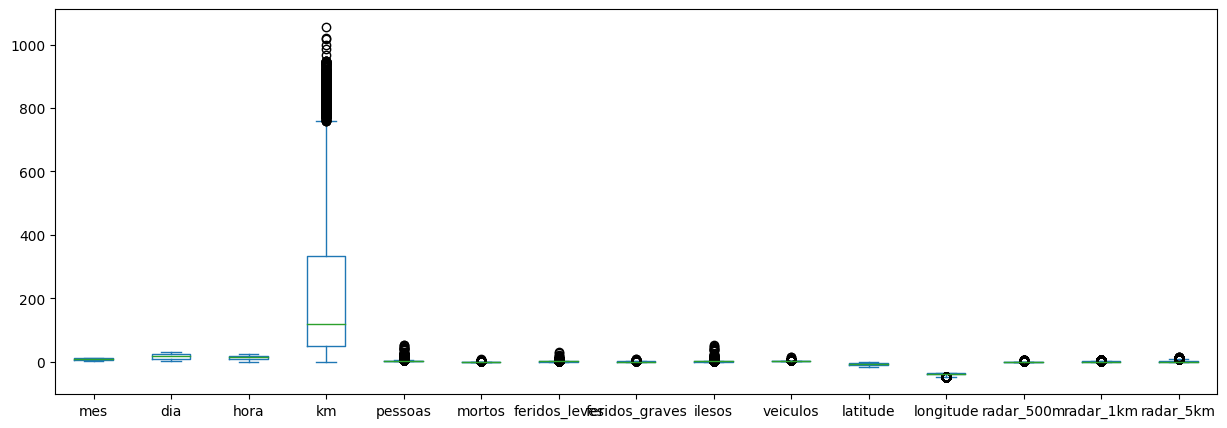

In [88]:
# Boxplots
ocorrencias.drop(columns=['ano']).plot.box(figsize=(15,5))

##### **km (z-score robusto)**

Após visualizarmos os boxplots (acima), vamos selecionar o atributo **'km'** para a análise de outliers com o método de **z-score robutos**.

<Axes: >

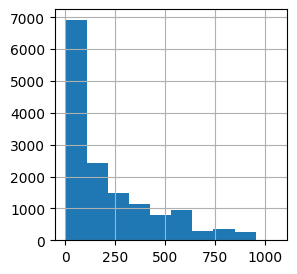

In [89]:
# Histograma de 'km'
ocorrencias.km.hist(figsize=(3,3))

A distribuição na escala original de 'km' não é simétrica, como se vê acima. Por isso, vamos experimentar transformar os dados para a **escala logarítmica**.

count    14592.000000
mean         1.996995
std          0.673718
min         -1.000000
25%          1.682145
50%          2.072250
75%          2.521269
max          3.023870
Name: km_log, dtype: float64


<Axes: >

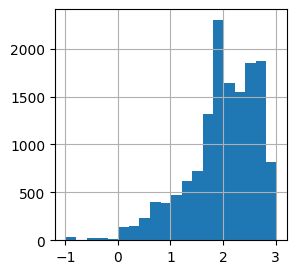

In [90]:
# Conversão para escala logaritmica
ocorrencias['km_log'] = log10(ocorrencias['km'] + 0.1) # acrescentando constante 0.1 para evitar log10(0)
print(ocorrencias['km_log'].describe())

ocorrencias.km_log.hist(figsize=(3,3), bins=20) # histograma

O resultado da transformação usando log10 ainda não aparenta ter gerado uma distribuição simétrica, pois apresenta relevante concentração de dados à direita.

Vamos então tentar outro método, usando a **transformação Box-Cox**. Seu principal objetivo é estabilizar a variância e tornar a distribuição dos dados mais próxima de uma normal. Internamente, a técnica combina transformações logaritmica e lineares.

Com o Box-Cox, como se vê abaixo, a distribuição aparenta ser mais simétrica. Desse modo, vamos utilizar a técnica de **z-score robusto** sobre `'km_boxcox'`.

<Axes: >

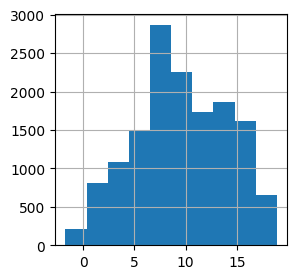

In [91]:
# Conversão de escala usando boxcox
ocorrencias['km_boxcox'], _ = boxcox(ocorrencias['km'] + 0.1)
ocorrencias['km_boxcox'].hist(figsize=(3, 3)) # histograma

<Axes: >

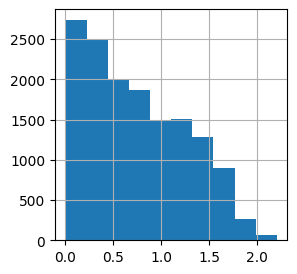

In [92]:
# cálculo do mad e dos z_score_robust
mad = stats.median_abs_deviation(ocorrencias['km_boxcox'], scale=0.6745) # mad não enviesado para desvio padrão
z_robust = abs((ocorrencias['km_boxcox'] - ocorrencias['km_boxcox'].median())/mad)
z_robust.hist(figsize=(3,3))  # histograma dos z_score

Pelos **resultados do z-score (acima)** e a convenção de que os outliers correspondem a valores superiores a 3 ou 3.5, **não temos candidatos a outliers**.

Contudo, **para aprofundamento, vamos verificar a calda do gráfico, com limiar superior a 2**. Como se vê abaixo, tratam-se de instâncias com 'km' próximo de zero (entre 0.0 e 0.3), mas a análise dos dados indica que os registros são compatíveis com as localidades indicadas.

Desse modo, **os dados serão mantidos**.

In [93]:
print(ocorrencias[z_robust > 2.0]['km'].describe())
ocorrencias[z_robust > 2.0]

count    62.000000
mean      0.087097
std       0.109371
min       0.000000
25%       0.000000
50%       0.000000
75%       0.200000
max       0.300000
Name: km, dtype: float64


,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox
33,2023-01-05 17:00:00,2023,1,5,17.000000,Tarde,quinta-feira,BA,116,0.1,VITORIA DA CONQUISTA,Conversão proibida,Colisão transversal,Com Vítimas Feridas,Pleno dia,Crescente,Nublado,Simples,Reta;Interseção de Vias,Não,2,0,1,0,1,2,-14.827030,-40.828790,SPRF-BA,DEL08-BA,UOP01-DEL08-BA,"(-0.001, 381.425]",0,0,0,-0.698970,-1.323889
391,2023-02-22 14:30:00,2023,2,22,14.500000,Tarde,quarta-feira,PI,316,0.1,TERESINA,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Ponte,Sim,3,0,1,0,2,3,-5.131168,-42.815640,SPRF-PI,DEL01-PI,UOP02-DEL01-PI,"(-0.001, 8.0]",0,0,0,-0.698970,-1.323889
710,2023-03-29 16:15:00,2023,3,29,16.250000,Tarde,quarta-feira,PE,101,0.2,JABOATAO DOS GUARARAPES,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Fatais,Pleno dia,Decrescente,Chuva,Simples,Reta,Sim,3,1,0,0,2,3,-8.183167,-34.950597,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,"(-0.001, 49.0]",0,0,1,-0.522879,-1.038982
1192,2023-05-23 03:32:00,2023,5,23,3.533333,Madrugada,terça-feira,MA,135,0.0,SAO LUIS,Reação tardia ou ineficiente do condutor,Colisão com objeto,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Dupla,Curva,Sim,1,0,0,0,1,1,-2.674703,-44.295652,SPRF-MA,DEL01-MA,UOP01-DEL01-MA,"(-0.001, 7.0]",0,1,5,-1.000000,-1.748528
1665,2023-07-07 20:00:00,2023,7,7,20.000000,Noite,sexta-feira,BA,407,0.2,JUAZEIRO,Ingestão de álcool pelo condutor,Colisão frontal,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Sim,2,0,0,0,2,2,-9.412749,-40.505916,SPRF-PE,DEL06-PE,UOP01-DEL06-PE,"(-0.001, 7.9]",0,0,4,-0.522879,-1.038982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14004,2023-12-18 09:30:00,2023,12,18,9.500000,Manhã,segunda-feira,BA,101,0.0,RIO REAL,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Sol,Simples,Curva;Em Obras,Não,2,0,1,0,1,1,-11.539233,-37.857036,SPRF-SE,DEL02-SE,UOP03-DEL02-SE,"(-0.001, 243.75]",0,0,0,-1.000000,-1.748528
14031,2023-12-19 07:40:00,2023,12,19,7.666667,Manhã,terça-feira,SE,235,0.0,ARACAJU,Reação tardia ou ineficiente do condutor,Colisão transversal,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Dupla,Interseção de Vias,Sim,2,0,1,0,1,2,-10.908700,-37.085500,SPRF-SE,DEL01-SE,UOP01-DEL01-SE,"(-0.001, 5.0]",0,0,1,-1.000000,-1.748528
14375,2023-12-28 07:53:00,2023,12,28,7.883333,Manhã,quinta-feira,CE,116,0.0,FORTALEZA,Ausência de reação do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Dupla,Reta,Não,3,0,1,0,2,3,-3.754584,-38.523407,SPRF-CE,DEL01-CE,UOP02-DEL01-CE,"(-0.001, 8.8]",0,0,4,-1.000000,-1.748528
14562,2023-12-21 22:33:00,2023,12,21,22.550000,Noite,quinta-feira,RN,427,0.0,CURRAIS NOVOS,Ingestão de álcool ou de substâncias psicoativ...,Atropelamento de Pedestre,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Interseção de Vias,Sim,2,0,1,1,0,2,-6.268529,-36.522582,SPRF-RN,DEL03-RN,UOP02-DEL03-RN,"(-0.001, 19.35]",0,1,1,-1.000000,-1.748528


<Axes: >

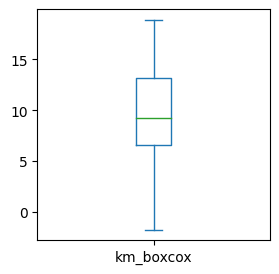

In [94]:
ocorrencias['km_boxcox'].plot.box(figsize=(3,3))

É importante observar que a contagem dos marcos quilométricos (km) em rodovias e estados distintos não são relacionadas, seria mais interessante realizar verificação de ouliers para combinações específicas de 'uf' e 'br'.

Desse modo, vamos refazer a verificação de outliers desse atributo para a BR-101 no Rio Grande do Norte.

<Axes: >

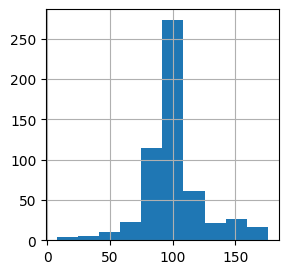

In [95]:
# Histograma de 'km' em BR-101/PE
ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')].km.hist(figsize=(3,3))

Como a distribuição nesse caso já aparenta simetria, não vamos realizar as transformações de escala.

<Axes: >

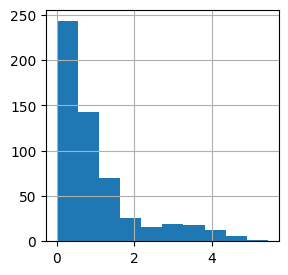

In [96]:
# cálculo do mad e dos z_score_robust
mad = stats.median_abs_deviation(ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km'], scale=0.6745) # mad não enviesado para desvio padrão
z_robust = abs((ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km'] - ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km'].median())/mad)
z_robust.hist(figsize=(3,3))  # histograma dos z_score

Diante da distribuição acima, vamos utilizar o limiar de 4.5 para avaliar os possíveis outliers.

Como se vê abaixo, são acidentes nos trechos de menor concentração dos dados, nas porções iniciais e finais da rodovia. Porém, a análise dos dados não indica estarem incorretos, por isso serão mantidos.

In [97]:
# outliers
print(ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')][z_robust > 4.5]['km'].describe())
ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')][z_robust > 4.5]

count      6.000000
mean      95.900000
std       87.862848
min        7.500000
25%       19.925000
50%       98.000000
75%      176.000000
max      176.000000
Name: km, dtype: float64


,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox
3691,2023-01-02 05:30:00,2023,1,2,5.500000,Madrugada,segunda-feira,RN,101,176.0,BAIA FORMOSA,Acumulo de água sobre o pavimento,Saída de leito carroçável,Com Vítimas Feridas,Amanhecer,Decrescente,Chuva,Dupla,Aclive;Curva,Não,3,0,3,0,0,1,-6.501549,-35.112026,SPRF-RN,DEL01-RN,UOP01-DEL01-RN,"(108.0, 176.0]",0,0,0,2.245759,10.609664
4298,2023-01-26 17:10:00,2023,1,26,17.166667,Tarde,quinta-feira,RN,101,19.9,TOUROS,Manobra de mudança de faixa,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Sol,Simples,Reta,Não,7,2,2,3,0,2,-5.291510,-35.437411,SPRF-RN,DEL02-RN,UOP01-DEL02-RN,"(7.499, 85.0]",0,0,0,1.301030,4.467658
4721,2023-01-01 05:15:00,2023,1,1,5.250000,Madrugada,domingo,RN,101,7.5,TOUROS,Animais na Pista,Saída de leito carroçável,Com Vítimas Feridas,Amanhecer,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,1,0,1,-5.209887,-35.493275,SPRF-RN,DEL02-RN,UOP01-DEL02-RN,"(7.499, 85.0]",0,0,0,0.880814,2.644818
7752,2023-05-29 07:50:00,2023,5,29,7.833333,Manhã,segunda-feira,RN,101,176.0,BAIA FORMOSA,Acumulo de água sobre o pavimento,Saída de leito carroçável,Com Vítimas Fatais,Pleno dia,Decrescente,Garoa/Chuvisco,Dupla,Curva,Não,3,1,1,0,1,1,-6.501665,-35.112002,SPRF-RN,DEL01-RN,UOP01-DEL01-RN,"(108.0, 176.0]",0,0,0,2.245759,10.609664
8914,2023-07-06 09:40:00,2023,7,6,9.666667,Manhã,quinta-feira,RN,101,176.0,BAIA FORMOSA,Chuva,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Dupla,Reta,Não,2,0,2,0,0,1,-6.501665,-35.112002,SPRF-RN,DEL01-RN,UOP01-DEL01-RN,"(108.0, 176.0]",0,0,0,2.245759,10.609664
14435,2023-12-30 05:00:00,2023,12,30,5.000000,Madrugada,sábado,RN,101,20.0,RIO DO FOGO,Animais na Pista,Atropelamento de Animal,Com Vítimas Feridas,Amanhecer,Decrescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,1,-5.295746,-35.429474,SPRF-RN,DEL02-RN,UOP01-DEL02-RN,"(7.499, 85.0]",0,0,0,1.303196,4.478249


##### **pessoas (DBSCAN)**

Neste caso não conseguimos uma distribuição simétrica do atributo, mesmo após transformação dos dados.

Vamos então utilizar o método (Density-Based Spatial Clustering of Applications with Noise), de modo univariado (aplicado apenas ao atributo 'pessoas').

count    14592.000000
mean         2.458402
std          1.946667
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         51.000000
Name: pessoas, dtype: float64


<Axes: >

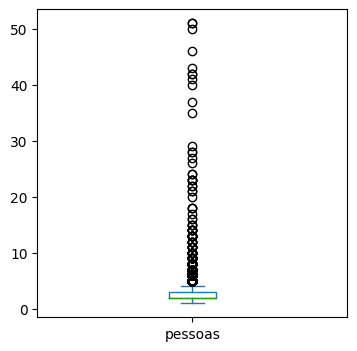

In [98]:
# Verificar distribuição de 'pessoas'
print(ocorrencias['pessoas'].describe())
ocorrencias['pessoas'].plot.box(figsize=(4,4))

<Axes: >

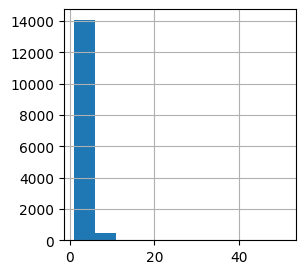

In [99]:
# Histograma
ocorrencias['pessoas'].hist(figsize=(3,3))

count    14592.000000
mean         0.324821
std          0.225922
min          0.000000
25%          0.301030
50%          0.301030
75%          0.477121
max          1.707570
Name: pessoas_log, dtype: float64


<Axes: >

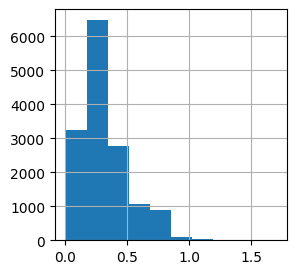

In [100]:
# Conversão para escala logarítmica
ocorrencias['pessoas_log'] = log10(ocorrencias['pessoas'])
print(ocorrencias['pessoas_log'].describe())
ocorrencias['pessoas_log'].hist(figsize=(3,3))

<Axes: >

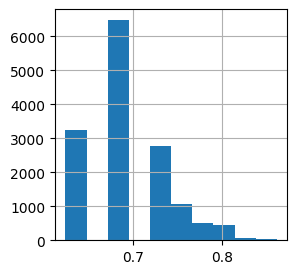

In [101]:
dados_positivos = ocorrencias['pessoas']  + np.abs(np.min(ocorrencias['pessoas'] )) + 1
ocorrencias['pessoas_boxcox'], _ = boxcox(dados_positivos)
ocorrencias['pessoas_boxcox'].hist(figsize=(3,3))

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

DBSCAN é uma técnica baseada em densidade que pode identificar outliers como pontos de ruído.

Agrupa pontos que estão próximos uns dos outros e considera pontos que estão isolados como outliers. Pode ser utilizada de modo uvariado ou multivariado.

Aqui aplicamos a técnica aos dados normalizados, configurando o raio máximo de vizinhança ao redor de um ponto como `eps=0.05`.

In [102]:
# Ajustar o modelo DBSCAN usando a coluna 'pessoas'
dbscan = DBSCAN(eps=0.05, min_samples=5)  # eps: distância da vizinhança
ocorrencias['pessoas_dbscan'] = dbscan.fit_predict(ocorrencias_norm[['pessoas']])

# Identificar os outliers (pontos rotulados como -1)
outliers_dbscan = ocorrencias[ocorrencias['pessoas_dbscan'] == -1]

print(len(outliers_dbscan))

6


In [103]:
print(outliers_dbscan['pessoas'].describe())
outliers_dbscan

count     6.000000
mean     45.000000
std       7.238784
min      35.000000
25%      39.250000
50%      48.000000
75%      50.750000
max      51.000000
Name: pessoas, dtype: float64


,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox,pessoas_log,pessoas_boxcox,pessoas_dbscan
2938,2023-11-05 20:45:00,2023,11,5,20.750000,Noite,domingo,BA,101,239.0,CONCEICAO DO ALMEIDA,Velocidade Incompatível,Colisão frontal,Com Vítimas Feridas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,51,0,1,0,50,5,-12.881180,-39.219990,SPRF-BA,DEL01-BA,UOP02-DEL01-BA,"(-0.001, 243.75]",0,0,0,2.378580,11.774601,1.707570,0.860987,-1
6719,2023-04-23 17:30:00,2023,4,23,17.500000,Tarde,domingo,BA,101,659.2,ITAPEBI,Chuva,Colisão frontal,Com Vítimas Fatais,Anoitecer,Crescente,Chuva,Simples,Curva,Não,50,2,0,0,47,3,-15.928046,-39.561696,SPRF-BA,DEL05-BA,UOP02-DEL05-BA,"(477.0, 745.0]",0,0,0,2.819083,16.346023,1.698970,0.860786,-1
10344,2023-08-22 23:08:00,2023,8,22,23.133333,Noite,terça-feira,CE,304,53.1,ARACATI,Animais na Pista,Atropelamento de Animal,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Não,35,0,1,0,34,2,-4.574024,-37.736361,SPRF-CE,DEL03-CE,UOP03-DEL03-CE,"(50.0, 54.3]",1,1,1,1.725912,6.821044,1.544068,0.856347,-1
13909,2023-12-15 20:40:00,2023,12,15,20.666667,Noite,sexta-feira,PE,316,17.8,ARARIPINA,Transitar na contramão,Colisão frontal,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Aclive;Reta,Não,37,0,1,1,35,2,-7.538974,-40.550993,SPRF-PE,DEL05-PE,UOP02-DEL05-PE,"(4.7989999999999995, 49.0]",0,0,0,1.252853,4.235501,1.568202,0.857152,-1
13969,2023-12-10 01:30:00,2023,12,10,1.500000,Madrugada,domingo,BA,020,75.0,SAO DESIDERIO,Iluminação deficiente,Incêndio,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,51,0,0,0,51,1,-12.801088,-45.953064,SPRF-BA,DEL10-BA,UOP01-DEL10-BA,"(60.0, 117.0]",0,0,0,1.875640,7.798127,1.707570,0.860987,-1
13994,2023-12-18 01:30:00,2023,12,18,1.500000,Madrugada,segunda-feira,PI,135,343.0,SANTA LUZ,Ausência de reação do condutor,Colisão com objeto,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Simples,Reta,Não,46,0,28,6,12,1,-9.036410,-44.306919,SPRF-PI,DEL03-PI,UOP02-DEL03-PI,"(303.0, 352.0]",0,0,0,2.535421,13.270545,1.662758,0.859892,-1


Os candidatos a ouliers encontrados são instâncias com valores elevados pe pessoas envolvidas, mesmo com pouco veículos.

Possivelmente, tratam-se de acidentes envolvendo ônibus, por isso o elevado quantitativo de acidentados.

#### Bivariado

Experimentamos possíveis combinações de variáveis que pudessem apresentar outliers.

Optamos pela razão pessoas/veículos.

<Axes: xlabel='pessoas', ylabel='ilesos'>

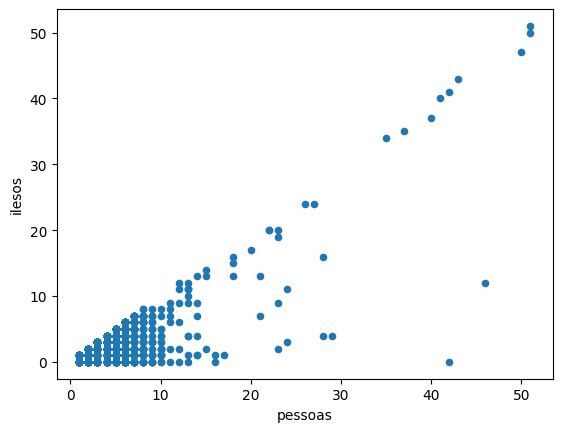

In [104]:
# Verifica relação ilesos x pessoas
ocorrencias.plot.scatter(x='pessoas',y='ilesos')

count    14592.000000
mean         0.351422
std          0.341928
min          0.000000
25%          0.000000
50%          0.333333
75%          0.500000
max          1.000000
Name: ilesos_pessoa, dtype: float64


<Axes: >

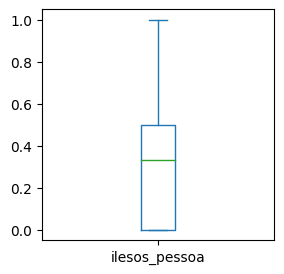

In [105]:
# ilesos / pessoas  ->  pelo boxplot não aparenta ter outliers
ocorrencias['ilesos_pessoa'] = ocorrencias['ilesos'] / ocorrencias['pessoas']
print(ocorrencias['ilesos_pessoa'].describe())
ocorrencias['ilesos_pessoa'].plot.box(figsize=(3,3))

A verificar a razão ilesos/pessoa, vemos que o boxplot não apresenta possíveis outliers.

A seguir, vamos verificar a razão **pessoas/veículo**.

##### pessoa_veiculo (Tukey)

count    14592.000000
mean         1.423934
std          1.239117
min          1.000000
25%          1.000000
50%          1.000000
75%          1.500000
max         51.000000
Name: pessoas_veiculo, dtype: float64


<Axes: >

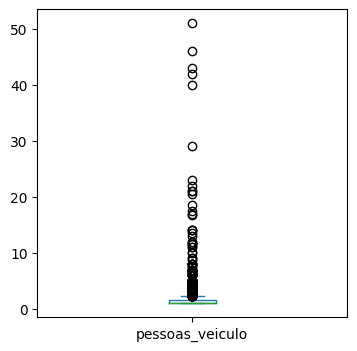

In [106]:
# Verificar relação pessoas x veículos
ocorrencias['pessoas_veiculo'] = ocorrencias['pessoas'] / ocorrencias['veiculos']
print(ocorrencias['pessoas_veiculo'].describe())
ocorrencias['pessoas_veiculo'].plot.box(figsize=(4,4))

Vemos que o corpo do boxplot está achatado, indicando alta concentração dos dados com baixos valores, com um denso rastro de pontos logo acima do whisker superior.

Nesse caso, ao aplicarmos o **método Tukey** vamos precisar reajustar esse limiar, para não tratar essa área densa de pontos como outliers.

<Axes: xlabel='veiculos', ylabel='pessoas'>

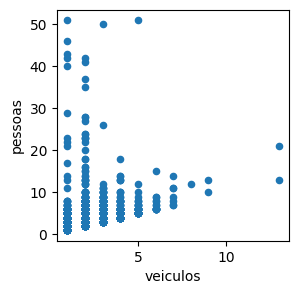

In [107]:
# dispersão
ocorrencias.plot.scatter(x='veiculos',y='pessoas', figsize=(3,3))

In [108]:
# Verificação dos quartis e IQR
q1 = ocorrencias['pessoas_veiculo'].quantile(q=0.25)
q3 = ocorrencias['pessoas_veiculo'].quantile(q=0.75)
iqr = q3 - q1
print(f"IQR: {iqr}")
print(f"Q1: {q1}")
print(f"Q3: {q3}")

IQR: 0.5
Q1: 1.0
Q3: 1.5


Ao verificaros os quartis e o IQR, temos valores muito baixos (`iqr==0.5`).

Desse modo, vamos aplicar o método de **Tukey**, mas para adequá-lo à realidade de dispersão do atributo e aos baixos valores do IQR e quartis, vamos aumentar os limiares para detecção dos outliers.

Em vez da constante padrão de 1,5 utilizada na fórmula, vamos modificá-la para 27.

In [109]:
# Outliers
outliers_tukey = ocorrencias[(ocorrencias['pessoas_veiculo'] > (q1-27*iqr)) & (ocorrencias['pessoas_veiculo'] > (q3+27*iqr))]
print(len(outliers_tukey))
outliers_tukey

15


,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox,pessoas_log,pessoas_boxcox,pessoas_dbscan,ilesos_pessoa,pessoas_veiculo
5626,2023-03-17 13:25:00,2023,3,17,13.416667,Tarde,sexta-feira,BA,242,811.0,BARREIRAS,Reação tardia ou ineficiente do condutor,Colisão com objeto,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Simples,Declive;Curva,Não,22,0,0,2,20,1,-12.126184,-45.139692,SPRF-BA,DEL10-BA,UOP01-DEL10-BA,"(780.0, 939.0]",0,0,0,2.909074,17.431940,1.342423,0.847507,0,0.909091,22.000000
6436,2023-02-28 17:30:00,2023,2,28,17.500000,Tarde,terça-feira,BA,242,690.0,CRISTOPOLIS,Acumulo de água sobre o pavimento,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Simples,Reta,Não,42,0,31,7,0,1,-12.222589,-44.073715,SPRF-BA,DEL10-BA,UOP02-DEL10-BA,"(537.5, 780.0]",0,0,0,2.838912,16.580467,1.623249,0.858823,1,0.000000,42.000000
6719,2023-04-23 17:30:00,2023,4,23,17.500000,Tarde,domingo,BA,101,659.2,ITAPEBI,Chuva,Colisão frontal,Com Vítimas Fatais,Anoitecer,Crescente,Chuva,Simples,Curva,Não,50,2,0,0,47,3,-15.928046,-39.561696,SPRF-BA,DEL05-BA,UOP02-DEL05-BA,"(477.0, 745.0]",0,0,0,2.819083,16.346023,1.698970,0.860786,-1,0.940000,16.666667
7076,2023-05-05 19:10:00,2023,5,5,19.166667,Noite,sexta-feira,CE,116,17.0,EUSEBIO,Ausência de reação do condutor,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Ponte,Sim,29,0,19,6,4,1,-3.897159,-38.503540,SPRF-CE,DEL01-CE,UOP02-DEL01-CE,"(8.8, 19.0]",2,2,6,1.232996,4.141681,1.462398,0.853254,0,0.137931,29.000000
7699,2023-05-08 00:55:00,2023,5,8,0.916667,Madrugada,segunda-feira,BA,101,230.0,SAPEACU,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Crescente,Chuva,Simples,Curva;Declive,Não,23,0,11,2,9,1,-12.826566,-39.199981,SPRF-BA,DEL01-BA,UOP02-DEL01-BA,"(-0.001, 243.75]",0,0,2,2.361917,11.623498,1.361728,0.848541,0,0.391304,23.000000
8105,2023-06-10 03:00:00,2023,6,10,3.000000,Madrugada,sábado,BA,110,124.0,ANTAS,Demais falhas mecânicas ou elétricas,Incêndio,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,43,0,0,0,43,1,-10.463977,-38.382942,SPRF-BA,DEL07-BA,UOP02-DEL07-BA,"(-0.001, 164.0]",0,0,0,2.093772,9.381903,1.633468,0.859109,1,1.000000,43.000000
8615,2023-06-25 20:26:00,2023,6,25,20.433333,Noite,domingo,CE,116,428.0,IPAUMIRIM,Reação tardia ou ineficiente do condutor,Colisão com objeto,Com Vítimas Feridas,Plena Noite,Crescente,Chuva,Simples,Rotatória,Não,17,0,11,5,1,1,-6.841868,-38.736918,SPRF-CE,DEL05-CE,UOP01-DEL05-CE,"(102.725, 545.9]",0,0,0,2.631545,14.256741,1.230449,0.840560,0,0.058824,17.000000
9474,2023-07-23 23:30:00,2023,7,23,23.500000,Noite,domingo,PI,343,109.0,COCAL,Transitar na contramão,Colisão frontal,Com Vítimas Fatais,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,41,1,0,0,40,2,-3.645938,-41.674126,SPRF-PI,DEL05-PI,UOP01-DEL05-PI,"(15.5, 287.7]",0,0,0,2.037825,8.956452,1.612784,0.858522,1,0.975610,20.500000
10344,2023-08-22 23:08:00,2023,8,22,23.133333,Noite,terça-feira,CE,304,53.1,ARACATI,Animais na Pista,Atropelamento de Animal,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Não,35,0,1,0,34,2,-4.574024,-37.736361,SPRF-CE,DEL03-CE,UOP03-DEL03-CE,"(50.0, 54.3]",1,1,1,1.725912,6.821044,1.544068,0.856347,-1,0.971429,17.500000
11746,2023-10-08 21:30:00,2023,10,8,21.500000,Noite,domingo,RN,304,160.0,ANGICOS,Problema na suspensão,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta;Em Obras,Não,21,0,8,0,13,1,-5.689562,-36.510821,SPRF-RN,DEL01-RN,UOP03-DEL01-RN,"(108.0, 287.0]",0,0,0,2.204391,10.264733,1.322219,0.846376,0,0.619048,21.000000


Os candidatos a outliers são ocorrências com altas médias de pessoas/veículo (entre 17 e 51).

Novamente são possivelmente acidentes envolvendo ônibus, que comportam diversos passageiros.

####Multivariado (Isolation Forest)

Como os dados não indicam ter uma distribuição gaussiana, vamos utilizar o método **IsolatioForest**.

Utilizamos os dados normalizados e configuramos uma baixa contaminação (0.001).

In [110]:
# classificador
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng, contamination=0.001)
clf.fit(ocorrencias_norm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, max_samples=100,
                random_state=RandomState(MT19937) at 0x7D0298AD9340)

In [111]:
# criar matriz com scores
scores = clf.predict(ocorrencias_norm)
print(f"Outliers: {((scores == -1).sum())}")

Outliers: 15


In [112]:
# Verificar outliers
ocorrencias['outlier'] = scores
ocorrencias[ocorrencias.outlier == -1]

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox,pessoas_log,pessoas_boxcox,pessoas_dbscan,ilesos_pessoa,pessoas_veiculo,outlier
127,2023-01-17 10:00:00,2023,1,17,10.000000,Manhã,terça-feira,BA,242,357.0,LENCOIS,Reação tardia ou ineficiente do condutor,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Nublado,Simples,Reta,Não,12,0,0,0,12,5,-12.470667,-41.366244,SPRF-BA,DEL08-BA,UOP04-DEL08-BA,"(0.999, 364.375]",0,0,0,2.552790,13.444711,1.079181,0.828156,0,1.000000,2.400000,-1
586,2023-03-15 13:45:00,2023,3,15,13.750000,Tarde,quarta-feira,BA,242,780.0,BARREIRAS,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Fatais,Pleno dia,Decrescente,Chuva,Simples,Curva,Não,9,1,1,0,7,5,-12.146331,-44.708991,SPRF-BA,DEL10-BA,UOP01-DEL10-BA,"(537.5, 780.0]",0,1,1,2.892150,17.223380,0.954243,0.814772,0,0.777778,1.800000,-1
1110,2023-05-14 04:45:00,2023,5,14,4.750000,Madrugada,domingo,MA,316,614.4,TIMON,Reação tardia ou ineficiente do condutor,Engavetamento,Com Vítimas Feridas,Plena Noite,Crescente,Chuva,Simples,Reta,Sim,18,0,4,1,13,4,-5.079532,-42.842918,SPRF-MA,DEL03-MA,UOP02-DEL03-MA,"(561.0, 621.0]",0,2,2,2.788522,15.989913,1.255273,0.842249,0,0.722222,4.500000,-1
1272,2023-05-31 21:30:00,2023,5,31,21.500000,Noite,quarta-feira,BA,020,197.0,LUIS EDUARDO MAGALHAES,Ultrapassagem Indevida,Colisão lateral mesmo sentido,Com Vítimas Fatais,Plena Noite,Crescente,Céu Claro,Simples,Reta,Não,7,1,4,0,2,4,-12.220557,-45.832389,SPRF-BA,DEL10-BA,UOP01-DEL10-BA,"(156.0, 208.0]",0,0,0,2.294687,11.028420,0.845098,0.800430,0,0.285714,1.750000,-1
1608,2023-07-03 06:05:00,2023,7,3,6.083333,Manhã,segunda-feira,BA,116,845.3,VITORIA DA CONQUISTA,Reação tardia ou ineficiente do condutor,Engavetamento,Com Vítimas Feridas,Amanhecer,Decrescente,Nevoeiro/Neblina,Simples,Aclive,Não,10,0,6,0,4,3,-15.024140,-40.953111,SPRF-BA,DEL08-BA,UOP01-DEL08-BA,"(760.275, 930.5]",0,0,0,2.927062,17.655857,1.000000,0.820034,0,0.400000,3.333333,-1
3404,2023-12-15 16:50:00,2023,12,15,16.833333,Tarde,sexta-feira,PB,101,35.5,SANTA RITA,Reação tardia ou ineficiente do condutor,Engavetamento,Com Vítimas Feridas,Pleno dia,Decrescente,Nublado,Múltipla,Curva;Declive;Interseção de Vi,Sim,13,0,0,3,10,13,-7.125266,-34.945275,SPRF-PB,DEL01-PB,UOP04-DEL01-PB,"(0.999, 78.0]",0,0,0,1.551450,5.784317,1.113943,0.831351,0,0.769231,1.000000,-1
3692,2023-01-02 05:30:00,2023,1,2,5.500000,Madrugada,segunda-feira,BA,135,122.0,RIACHAO DAS NEVES,Ausência de reação do condutor,Colisão frontal,Com Vítimas Fatais,Amanhecer,Decrescente,Céu Claro,Simples,Reta,Não,5,1,0,1,3,2,-11.756252,-44.905866,SPRF-BA,DEL08-BA,UOP04-DEL08-BA,"(19.999, 146.0]",0,0,0,2.086716,9.327483,0.698970,0.777112,0,0.600000,2.500000,-1
3736,2023-01-03 18:30:00,2023,1,3,18.500000,Noite,terça-feira,BA,101,710.0,EUNAPOLIS,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Fatais,Anoitecer,Crescente,Nublado,Simples,Reta,Não,7,2,1,4,0,2,-16.319254,-39.597344,SPRF-BA,DEL09-BA,UOP01-DEL09-BA,"(477.0, 745.0]",0,0,2,2.851320,16.728537,0.845098,0.800430,0,0.000000,3.500000,-1
6719,2023-04-23 17:30:00,2023,4,23,17.500000,Tarde,domingo,BA,101,659.2,ITAPEBI,Chuva,Colisão frontal,Com Vítimas Fatais,Anoitecer,Crescente,Chuva,Simples,Curva,Não,50,2,0,0,47,3,-15.928046,-39.561696,SPRF-BA,DEL05-BA,UOP02-DEL05-BA,"(477.0, 745.0]",0,0,0,2.819083,16.346023,1.698970,0.860786,-1,0.940000,16.666667,-1
8729,2023-06-29 05:20:00,2023,6,29,5.333333,Madrugada,quinta-feira,BA,020,87.0,SAO DESIDERIO,Transitar na contramão,Colisão frontal,Com Vítimas Fatais,Amanhecer,Crescente,Céu Claro,Simples,Reta,Não,9,2,0,4,3,3,-13.190230,-46.035942,SPRF-BA,DEL10-BA,UOP01-DEL10-BA,"(60.0, 117.0]",0,0,0,1.940018,8.244957,0.95424

Apesar da indicação dos candidatos a outliers, pela análise das ocorrências, concluímos que devem ser mantidas.

In [113]:
from sklearn.covariance import EllipticEnvelope
detector = EllipticEnvelope(contamination=0.01)
detector.fit(ocorrencias_code)

EllipticEnvelope(contamination=0.01)

In [114]:
scores = detector.predict(ocorrencias_code)
scores

array([1, 1, 1, ..., 1, 1, 1])

In [115]:
df = ocorrencias_code.copy()
df['outlier'] = scores
df.head()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,outlier
0,1.672610e+09,2023.0,1.0,1.0,21.833333,3.0,0.0,1.0,6.0,366.0,588.0,71.0,8.0,2.0,2.0,1.0,2.0,2.0,147.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,-11.725140,-38.986429,1.0,10.0,10.0,16.0,1
1,1.672650e+09,2023.0,1.0,2.0,9.000000,1.0,3.0,6.0,16.0,7.7,616.0,0.0,7.0,1.0,3.0,1.0,5.0,1.0,147.0,1.0,3.0,0.0,2.0,0.0,1.0,2.0,-5.155846,-42.771733,6.0,6.0,49.0,4.0,1
2,1.672654e+09,2023.0,1.0,2.0,10.250000,1.0,3.0,5.0,3.0,68.0,484.0,8.0,10.0,1.0,3.0,1.0,4.0,2.0,223.0,1.0,5.0,0.0,2.0,0.0,3.0,3.0,-8.050743,-34.945806,5.0,5.0,5.0,156.0,1
3,1.672666e+09,2023.0,1.0,2.0,13.400000,2.0,3.0,5.0,3.0,57.0,438.0,57.0,8.0,1.0,3.0,0.0,4.0,0.0,22.0,0.0,3.0,0.0,1.0,0.0,1.0,2.0,-7.963462,-34.915135,5.0,5.0,48.0,132.0,1
4,1.672663e+09,2023.0,1.0,2.0,12.500000,2.0,3.0,3.0,16.0,615.7,621.0,14.0,8.0,1.0,3.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,1.0,0.0,1.0,2.0,-5.086548,-42.837265,3.0,21.0,61.0,306.0,1


In [116]:
# Outliers identificados
df[df.outlier == -1]

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,outlier
49,1.673184e+09,2023.0,1.0,8.0,13.333333,2.0,0.0,1.0,6.0,815.0,650.0,39.0,10.0,1.0,3.0,0.0,4.0,2.0,154.0,1.0,7.0,0.0,1.0,0.0,6.0,4.0,-14.773153,-40.722018,1.0,40.0,40.0,312.0,-1
127,1.673950e+09,2023.0,1.0,17.0,10.000000,1.0,6.0,1.0,14.0,357.0,340.0,57.0,8.0,2.0,3.0,1.0,4.0,2.0,147.0,0.0,12.0,0.0,0.0,0.0,12.0,5.0,-12.470667,-41.366244,1.0,40.0,106.0,34.0,-1
202,1.674990e+09,2023.0,1.0,29.0,10.916667,1.0,0.0,1.0,6.0,911.6,123.0,14.0,8.0,1.0,3.0,1.0,1.0,2.0,12.0,0.0,9.0,0.0,7.0,0.0,2.0,3.0,-15.446413,-41.226150,1.0,40.0,101.0,312.0,-1
230,1.675336e+09,2023.0,2.0,2.0,11.250000,1.0,2.0,2.0,15.0,48.4,36.0,0.0,8.0,1.0,3.0,0.0,5.0,0.0,203.0,1.0,9.0,0.0,8.0,0.0,1.0,3.0,-4.579484,-37.777412,2.0,20.0,90.0,129.0,-1
259,1.675564e+09,2023.0,2.0,5.0,2.416667,0.0,0.0,1.0,40.0,413.6,254.0,67.0,4.0,1.0,2.0,1.0,1.0,2.0,76.0,0.0,18.0,0.0,2.0,0.0,16.0,2.0,-13.932870,-42.564630,1.0,40.0,106.0,293.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292,1.703528e+09,2023.0,12.0,25.0,18.333333,3.0,3.0,3.0,9.0,674.0,2.0,14.0,10.0,2.0,1.0,0.0,1.0,2.0,148.0,1.0,7.0,0.0,0.0,0.0,7.0,3.0,-4.934126,-47.453592,3.0,28.0,94.0,310.0,-1
14330,1.703602e+09,2023.0,12.0,26.0,14.833333,2.0,6.0,1.0,3.0,269.3,530.0,70.0,5.0,1.0,3.0,1.0,5.0,2.0,1.0,0.0,7.0,0.0,2.0,0.0,5.0,3.0,-13.019861,-39.291916,1.0,1.0,44.0,249.0,-1
14362,1.703674e+09,2023.0,12.0,27.0,10.833333,1.0,1.0,1.0,27.0,200.0,110.0,41.0,4.0,1.0,3.0,0.0,1.0,2.0,147.0,1.0,9.0,0.0,5.0,1.0,3.0,2.0,-11.104470,-40.070768,1.0,26.0,66.0,221.0,-1
14566,1.698498e+09,2023.0,10.0,28.0,12.916667,2.0,5.0,5.0,4.0,77.0,8.0,40.0,4.0,0.0,3.0,0.0,1.0,2.0,58.0,0.0,10.0,1.0,6.0,1.0,2.0,4.0,-8.375978,-35.983662,5.0,14.0,14.0,155.0,-1


In [117]:
# Dados sem outliers
df[df.outlier != -1]

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,outlier
0,1.672610e+09,2023.0,1.0,1.0,21.833333,3.0,0.0,1.0,6.0,366.0,588.0,71.0,8.0,2.0,2.0,1.0,2.0,2.0,147.0,0.0,2.0,0.0,0.0,0.0,2.000000e+00,2.0,-11.725140,-38.986429,1.0,10.0,10.0,16.0,1
1,1.672650e+09,2023.0,1.0,2.0,9.000000,1.0,3.0,6.0,16.0,7.7,616.0,0.0,7.0,1.0,3.0,1.0,5.0,1.0,147.0,1.0,3.0,0.0,2.0,0.0,1.000000e+00,2.0,-5.155846,-42.771733,6.0,6.0,49.0,4.0,1
2,1.672654e+09,2023.0,1.0,2.0,10.250000,1.0,3.0,5.0,3.0,68.0,484.0,8.0,10.0,1.0,3.0,1.0,4.0,2.0,223.0,1.0,5.0,0.0,2.0,0.0,3.000000e+00,3.0,-8.050743,-34.945806,5.0,5.0,5.0,156.0,1
3,1.672666e+09,2023.0,1.0,2.0,13.400000,2.0,3.0,5.0,3.0,57.0,438.0,57.0,8.0,1.0,3.0,0.0,4.0,0.0,22.0,0.0,3.0,0.0,1.0,0.0,1.000000e+00,2.0,-7.963462,-34.915135,5.0,5.0,48.0,132.0,1
4,1.672663e+09,2023.0,1.0,2.0,12.500000,2.0,3.0,3.0,16.0,615.7,621.0,14.0,8.0,1.0,3.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,1.0,0.0,1.000000e+00,2.0,-5.086548,-42.837265,3.0,21.0,61.0,306.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,1.699472e+09,2023.0,11.0,8.0,19.666667,3.0,1.0,1.0,17.0,437.0,491.0,51.0,1.0,1.0,2.0,0.0,1.0,2.0,147.0,1.0,2.0,0.0,0.0,1.0,1.110223e-16,2.0,-11.801755,-39.398370,1.0,26.0,66.0,17.0,1
14588,1.702926e+09,2023.0,12.0,18.0,19.000000,3.0,3.0,6.0,19.0,33.0,429.0,40.0,13.0,1.0,2.0,1.0,4.0,2.0,131.0,0.0,1.0,0.0,0.0,1.0,1.110223e-16,1.0,-3.097037,-41.780117,6.0,36.0,36.0,89.0,1
14589,1.694020e+09,2023.0,9.0,6.0,17.250000,2.0,1.0,1.0,3.0,876.0,610.0,0.0,7.0,1.0,1.0,1.0,1.0,2.0,147.0,1.0,2.0,0.0,1.0,1.0,1.110223e-16,2.0,-17.538061,-39.714371,1.0,41.0,79.0,311.0,1
14590,1.702029e+09,2023.0,12.0,8.0,9.966667,1.0,4.0,3.0,16.0,29.0,472.0,57.0,2.0,1.0,3.0,0.0,1.0,2.0,147.0,0.0,1.0,0.0,1.0,0.0,1.110223e-16,1.0,-2.322658,-45.835350,3.0,12.0,54.0,22.0,1


In [118]:
# Obter os índices a serem removidos
indices_remover = df[df['outlier'] == -1].index

# Remover as linhas correspondentes aos índices
ocorrencias = ocorrencias.drop(indices_remover)
ocorrencias_code = ocorrencias_code.drop(indices_remover)
ocorrencias

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox,pessoas_log,pessoas_boxcox,pessoas_dbscan,ilesos_pessoa,pessoas_veiculo,outlier
0,2023-01-01 21:50:00,2023,1,1,21.833333,Noite,domingo,BA,116,366.0,SERRINHA,Velocidade Incompatível,Colisão traseira,Sem Vítimas,Plena Noite,Decrescente,Garoa/Chuvisco,Simples,Reta,Não,2,0,0,0,2,2,-11.725140,-38.986429,SPRF-BA,DEL02-BA,UOP01-DEL02-BA,"(-0.001, 381.425]",0,0,0,2.563600,13.553992,0.301030,0.693223,0,1.000000,1.000000,1
1,2023-01-02 09:00:00,2023,1,2,9.000000,Manhã,segunda-feira,PI,316,7.7,TERESINA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Decrescente,Sol,Múltipla,Reta,Sim,3,0,2,0,1,2,-5.155846,-42.771733,SPRF-PI,DEL01-PI,UOP02-DEL01-PI,"(-0.001, 8.0]",0,0,0,0.892095,2.688189,0.477121,0.733227,0,0.333333,1.500000,1
2,2023-01-02 10:15:00,2023,1,2,10.250000,Manhã,segunda-feira,PE,101,68.0,RECIFE,Ausência de reação do condutor,Engavetamento,Com Vítimas Feridas,Pleno dia,Decrescente,Nublado,Simples,Viaduto,Sim,5,0,2,0,3,3,-8.050743,-34.945806,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,"(67.5, 77.5]",0,0,6,1.833147,7.512180,0.698970,0.777112,0,0.600000,1.666667,1
3,2023-01-02 13:24:00,2023,1,2,13.400000,Tarde,segunda-feira,PE,101,57.0,PAULISTA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Nublado,Dupla,Curva,Não,3,0,1,0,1,2,-7.963462,-34.915135,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,"(49.0, 67.5]",2,2,6,1.756636,7.014703,0.477121,0.733227,0,0.333333,1.500000,1
4,2023-01-02 12:30:00,2023,1,2,12.500000,Tarde,segunda-feira,MA,316,615.7,TIMON,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,0,1,2,-5.086548,-42.837265,SPRF-MA,DEL03-MA,UOP02-DEL03-MA,"(561.0, 621.0]",2,2,3,2.789440,16.000516,0.301030,0.693223,0,0.500000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,2023-11-08 19:40:00,2023,11,8,19.666667,Noite,quarta-feira,BA,324,437.0,RIACHAO DO JACUIPE,Pedestre cruzava a pista fora da faixa,Atropelamento de Pedestre,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Sim,2,0,0,1,0,2,-11.801755,-39.398370,SPRF-BA,DEL04-BA,UOP02-DEL04-BA,"(-0.001, 519.95]",0,0,1,2.640581,14.352293,0.301030,0.693223,0,0.000000,1.000000,1
14588,2023-12-18 19:00:00,2023,12,18,19.000000,Noite,segunda-feira,PI,343,33.0,PARNAIBA,Mal súbito do condutor,Queda de ocupante de veículo,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Simples,Interseção de Vias;Reta,Não,1,0,0,1,0,1,-3.097037,-41.780117,SPRF-PI,DEL05-PI,UOP01-DEL05-PI,"(15.5, 287.7]",0,0,0,1.519828,5.607348,0.000000,0.623926,0,0.000000,1.000000,1
14589,2023-09-06 17:15:00,2023,9,6,17.250000,Tarde,quarta-feira,BA,101,876.0,TEIXEIRA DE FREITAS,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Anoitecer,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,1,0,2,-17.538061,-39.714371,SPRF-BA,DEL09-BA,UOP02-DEL09-BA,"(745.0, 948.3]",0,0,5,2.942554,17.850574,0.301030,0.693223,0,0.000000,1.000000,1
14590,2023-12-08 09:58:00,2023,12,8,9.966667,Manhã,sexta-feira,MA,316,29.0,PRESIDENTE MEDICI,Reação tardia ou ineficiente do condutor,Capotamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,1,-2.322658,-45.835350,SPRF-MA,DEL02-MA,UOP02-DEL02-MA,"(0.099, 261.0]",0,0,0,1.463893,5.302131,0.000000,0.623926,0,0.000000,1.000000,1


In [119]:
# Confirmando que outliers foram retirados de 'ocorrencias' e 'ocorrencias_code'
len(ocorrencias) == len(df[df.outlier != -1]) == len(ocorrencias_code)

True

In [148]:
# PARA AGILIZAR TESTES - salvar csvs
'''ocorrencias_code.to_csv(pathDrive + 'ocorrencias_code.csv')
ocorrencias.to_csv(pathDrive + 'acidentes2023_ne.csv', index=False, encoding='latin1')'''

"ocorrencias_code.to_csv(pathDrive + 'ocorrencias_code.csv')\nocorrencias.to_csv(pathDrive + 'acidentes2023_ne.csv', index=False, encoding='latin1')"

In [121]:
ocorrencias.dtypes

data_hora                 datetime64[ns]
ano                                int64
mes                                int64
dia                                int64
hora                             float64
periodo_horario                 category
dia_semana                      category
uf                              category
br                              category
km                               float64
municipio                       category
causa_acidente                  category
tipo_acidente                   category
classificacao_acidente          category
fase_dia                        category
sentido_via                     category
condicao_metereologica          category
tipo_pista                      category
tracado_via                     category
uso_solo                        category
pessoas                            int64
mortos                             int64
feridos_leves                      int64
feridos_graves                     int64
ilesos          

###### *Checkpoint*


In [149]:
# PARA AGILIZAR TESTES - abrir csvs
'''ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')
ocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})
categoricos = ['dia_semana', 'uf', 'br', 'municipio', 'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via',
               'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'regional', 'delegacia', 'uop']
ocorrencias[categoricos] = ocorrencias[categoricos].astype('category')
ocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])'''


"ocorrencias_code = pd.read_csv(pathDrive + 'ocorrencias_code.csv')\nocorrencias = pd.read_csv(pathDrive + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})\ncategoricos = ['dia_semana', 'uf', 'br', 'municipio', 'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via',\n               'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'regional', 'delegacia', 'uop']\nocorrencias[categoricos] = ocorrencias[categoricos].astype('category')\nocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])"

In [123]:
ocorrencias.dtypes

data_hora                 datetime64[ns]
ano                                int64
mes                                int64
dia                                int64
hora                             float64
periodo_horario                 category
dia_semana                      category
uf                              category
br                              category
km                               float64
municipio                       category
causa_acidente                  category
tipo_acidente                   category
classificacao_acidente          category
fase_dia                        category
sentido_via                     category
condicao_metereologica          category
tipo_pista                      category
tracado_via                     category
uso_solo                        category
pessoas                            int64
mortos                             int64
feridos_leves                      int64
feridos_graves                     int64
ilesos          

In [124]:
ocorrencias

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br,radar_500m,radar_1km,radar_5km,km_log,km_boxcox,pessoas_log,pessoas_boxcox,pessoas_dbscan,ilesos_pessoa,pessoas_veiculo,outlier
0,2023-01-01 21:50:00,2023,1,1,21.833333,Noite,domingo,BA,116,366.0,SERRINHA,Velocidade Incompatível,Colisão traseira,Sem Vítimas,Plena Noite,Decrescente,Garoa/Chuvisco,Simples,Reta,Não,2,0,0,0,2,2,-11.725140,-38.986429,SPRF-BA,DEL02-BA,UOP01-DEL02-BA,"(-0.001, 381.425]",0,0,0,2.563600,13.553992,0.301030,0.693223,0,1.000000,1.000000,1
1,2023-01-02 09:00:00,2023,1,2,9.000000,Manhã,segunda-feira,PI,316,7.7,TERESINA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Decrescente,Sol,Múltipla,Reta,Sim,3,0,2,0,1,2,-5.155846,-42.771733,SPRF-PI,DEL01-PI,UOP02-DEL01-PI,"(-0.001, 8.0]",0,0,0,0.892095,2.688189,0.477121,0.733227,0,0.333333,1.500000,1
2,2023-01-02 10:15:00,2023,1,2,10.250000,Manhã,segunda-feira,PE,101,68.0,RECIFE,Ausência de reação do condutor,Engavetamento,Com Vítimas Feridas,Pleno dia,Decrescente,Nublado,Simples,Viaduto,Sim,5,0,2,0,3,3,-8.050743,-34.945806,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,"(67.5, 77.5]",0,0,6,1.833147,7.512180,0.698970,0.777112,0,0.600000,1.666667,1
3,2023-01-02 13:24:00,2023,1,2,13.400000,Tarde,segunda-feira,PE,101,57.0,PAULISTA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Nublado,Dupla,Curva,Não,3,0,1,0,1,2,-7.963462,-34.915135,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,"(49.0, 67.5]",2,2,6,1.756636,7.014703,0.477121,0.733227,0,0.333333,1.500000,1
4,2023-01-02 12:30:00,2023,1,2,12.500000,Tarde,segunda-feira,MA,316,615.7,TIMON,Condutor deixou de manter distância do veículo...,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,0,1,2,-5.086548,-42.837265,SPRF-MA,DEL03-MA,UOP02-DEL03-MA,"(561.0, 621.0]",2,2,3,2.789440,16.000516,0.301030,0.693223,0,0.500000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,2023-11-08 19:40:00,2023,11,8,19.666667,Noite,quarta-feira,BA,324,437.0,RIACHAO DO JACUIPE,Pedestre cruzava a pista fora da faixa,Atropelamento de Pedestre,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Sim,2,0,0,1,0,2,-11.801755,-39.398370,SPRF-BA,DEL04-BA,UOP02-DEL04-BA,"(-0.001, 519.95]",0,0,1,2.640581,14.352293,0.301030,0.693223,0,0.000000,1.000000,1
14588,2023-12-18 19:00:00,2023,12,18,19.000000,Noite,segunda-feira,PI,343,33.0,PARNAIBA,Mal súbito do condutor,Queda de ocupante de veículo,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Simples,Interseção de Vias;Reta,Não,1,0,0,1,0,1,-3.097037,-41.780117,SPRF-PI,DEL05-PI,UOP01-DEL05-PI,"(15.5, 287.7]",0,0,0,1.519828,5.607348,0.000000,0.623926,0,0.000000,1.000000,1
14589,2023-09-06 17:15:00,2023,9,6,17.250000,Tarde,quarta-feira,BA,101,876.0,TEIXEIRA DE FREITAS,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Anoitecer,Decrescente,Céu Claro,Simples,Reta,Sim,2,0,1,1,0,2,-17.538061,-39.714371,SPRF-BA,DEL09-BA,UOP02-DEL09-BA,"(745.0, 948.3]",0,0,5,2.942554,17.850574,0.301030,0.693223,0,0.000000,1.000000,1
14590,2023-12-08 09:58:00,2023,12,8,9.966667,Manhã,sexta-feira,MA,316,29.0,PRESIDENTE MEDICI,Reação tardia ou ineficiente do condutor,Capotamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,1,-2.322658,-45.835350,SPRF-MA,DEL02-MA,UOP02-DEL02-MA,"(0.099, 261.0]",0,0,0,1.463893,5.302131,0.000000,0.623926,0,0.000000,1.000000,1


# ESTATÍSTICAS DESCRITIVAS

Nas estatísticas descritivas iremos explorar abordagens univariadas e bivariadas.

## Univariadas

### Pesoas envolvidas (estatísticas simples)

Vamos observar dados como média, mediana, moda, variância, desvio padrão e quantis.

In [ ]:
# Pessoas envolvidas

print("Pessoas Envolvidas:\n")
print(f"Média: {ocorrencias.pessoas.mean()}")
print(f"Mediana: {ocorrencias.pessoas.median()}")
print(f"Moda:\n{ocorrencias.pessoas.mode()}")
print(f"Variância: {ocorrencias.pessoas.var()}")
print(f"Desvio Padrão: {ocorrencias.pessoas.std()}")

Pessoas Envolvidas:

Média: 2.4584018640350878
Mediana: 2.0
Moda:
0    2
Name: pessoas, dtype: int64
Variância: 3.789510652557693
Desvio Padrão: 1.9466665488875319


In [ ]:
ocorrencias.pessoas.describe()

count    14592.000000
mean         2.458402
std          1.946667
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         51.000000
Name: pessoas, dtype: float64

In [ ]:
# Reabrir CSV SE NECESSÁRIO (se sessão do notebook for reiniciada)
#ocorrencias = pd.read_csv(pathDrive + 'acidentes2023_tratado.csv', encoding='latin1', dtype={'br':'str'})

In [ ]:
# Quantidade de Linhas e Colunas
print(f"Linhas:  {len(ocorrencias)}\nColunas: {ocorrencias.shape[1]}")

Linhas:  14592
Colunas: 43


### Acidentes por UF

Vamos observar a quantidade de acidentes, de mortos e de feridos graves em cada estado (UF).

Para as visualizações utilizaremos tabelas e gráfico de barras agrupadas.

In [125]:
# Agrupando por 'uf
  # métricas: 'mortos', 'feridos_graves' e 'acidentes'
uf = ocorrencias.groupby('uf').agg({
    'mortos': 'sum',             # Soma de mortos
    'feridos_graves': 'sum',     # Soma de feridos graves
    'uf': 'count'                # Contagem de ocorrências (acidentes)
})
uf.rename(columns={'uf': 'acidentes'}, inplace=True)

uf

,mortos,feridos_graves,acidentes
uf,,,
AL,63,233,612
BA,546,1181,3665
CE,135,444,1348
MA,246,486,1149
PB,127,515,1548
PE,266,1016,2974
PI,147,474,1262
RN,97,418,1355
SE,38,170,533


In [ ]:
# média das métricas selecionadas
medias = uf.mean()
medias

mortos             189.888889
feridos_graves     565.888889
acidentes         1621.333333
dtype: float64

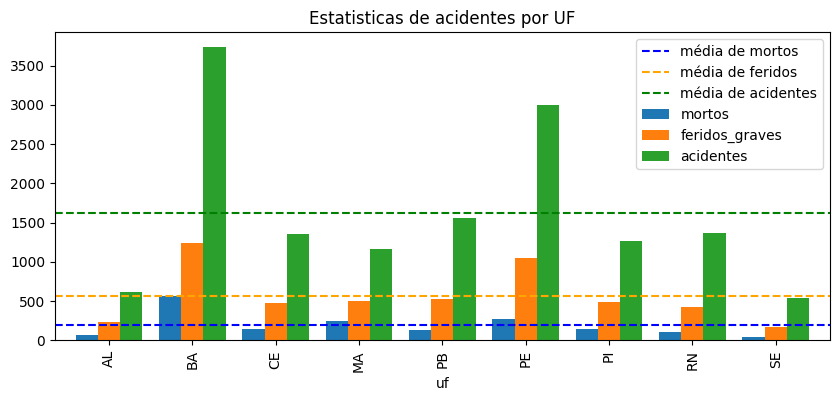

In [ ]:
# Criar gráfico de barras
uf.plot(kind='bar', width=0.8, figsize=(10,4), title="Estatisticas de acidentes por UF")

# Adicionar linha da média
plt.axhline(y=medias[0], color='blue', linestyle='--', label='média de mortos')
plt.axhline(y=medias[1], color='orange', linestyle='--', label='média de feridos')
plt.axhline(y=medias[2], color='green', linestyle='--', label='média de acidentes')

# Adicionar legenda
plt.legend()

# Mostrar o gráfico
plt.show()

In [ ]:
# UFs com maior quantidade de acidentes
top2_uf = uf.nlargest(2, 'acidentes')
top2_uf

,mortos,feridos_graves,acidentes
uf,,,
BA,564,1237,3739
PE,276,1044,2994


Das análises, vemos que os estados com mais acidentes são Bahia e Pernambuco, respondento cada um pelo percentual indicado abaixo:

In [ ]:
# Percentual dos acidentes em relação ao total
total_acidentes = uf.acidentes.sum()
top2_uf['acidentes_percent'] = top2_uf['acidentes'].apply(lambda x: x/total_acidentes*100)
top2_uf.acidentes_percent

uf
BA    25.623629
PE    20.518092
Name: acidentes_percent, dtype: float64

### Acidentes por Rodovia em Pernambuco

Vamos observar a quantidade de acidentes, de mortos e de feridos graves em cada rodovia (BR) no estado de Pernambuo.

Para as visualizações utilizaremos tabelas e gráfico de barras agrupadas.

In [131]:
# Agrupando por 'br' em Pernambuco
  # métricas: 'mortos', 'feridos_graves' e 'acidentes'
br = ocorrencias[ocorrencias.uf == 'PE'].groupby('br').agg({
    'mortos': 'sum',             # Soma de mortos
    'feridos_graves': 'sum',     # Soma de feridos graves
    'br': 'count'                # Contagem de ocorrências (acidentes)
})
br.rename(columns={'br': 'acidentes'}, inplace=True)
br = br[br.acidentes != 0] # drop zeros
br

,mortos,feridos_graves,acidentes
br,,,
101,60,355,1161
104,22,48,192
110,6,5,18
116,8,11,31
232,75,328,838
316,26,56,109
407,10,25,95
408,15,41,124
423,23,63,167


In [132]:
# média das métricas selecionadas
medias = br.mean()
medias

mortos             24.181818
feridos_graves     92.363636
acidentes         270.363636
dtype: float64

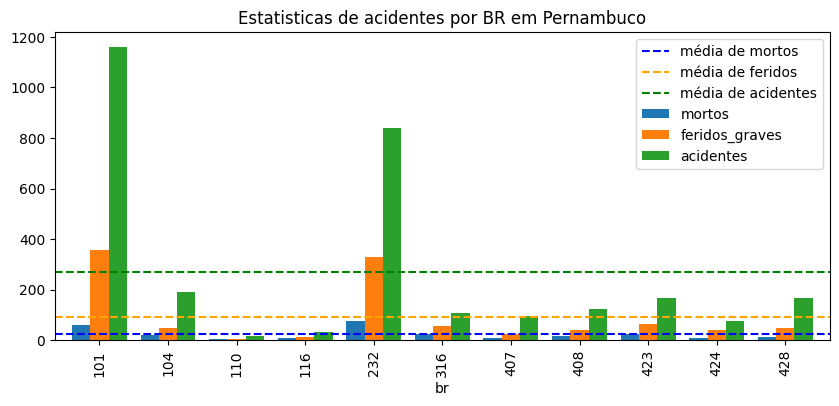

In [133]:
# Criar gráfico de barras
br.plot(kind='bar', width=0.8, figsize=(10,4), title="Estatisticas de acidentes por BR em Pernambuco")

# Adicionar linha da média
plt.axhline(y=medias[0], color='blue', linestyle='--', label='média de mortos')
plt.axhline(y=medias[1], color='orange', linestyle='--', label='média de feridos')
plt.axhline(y=medias[2], color='green', linestyle='--', label='média de acidentes')

# Adicionar legenda
plt.legend()

# Mostrar o gráfico
plt.show()

In [134]:
# UFs com maior quantidade de acidentes
top2_br = br.nlargest(2, 'acidentes')
top2_br

,mortos,feridos_graves,acidentes
br,,,
101,60,355,1161
232,75,328,838


Das análises, vemos que as BRs em Pernambuco com mais acidentes são a 101 e 232, respondento cada uma pelo percentual indicado abaixo:

In [135]:
# Percentual dos acidentes em relação ao total
total_acidentes = br.acidentes.sum()
top2_br['acidentes_percent'] = top2_br['acidentes'].apply(lambda x: x/total_acidentes*100)
top2_br.acidentes_percent

br
101    39.038332
232    28.177539
Name: acidentes_percent, dtype: float64

### Tempo

Vamos observar várias distribuições temporais, com visualização mediante gráficos de barras horizontais e verticais.

- Distribuição mensal
- Dias da semana
- Distribuição horária
- Períodos do dia

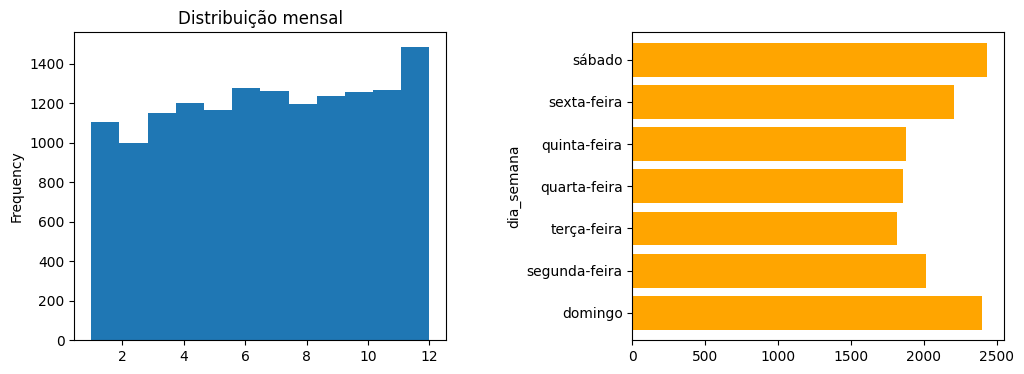

In [ ]:
# Mês e Dia da Semana
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ocorrencias['mes'].plot.hist(bins=12, title="Distribuição mensal", ax=axs[0])
ocorrencias.groupby('dia_semana').size().reindex(['domingo', 'segunda-feira', # reindex para seguir ordem natural dos dias da semana
  'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado']).plot(kind='barh', width=0.8, ax=axs[1], color='orange')
plt.subplots_adjust(wspace=0.5) # disntância entre subplots
plt.show()

Nota-se que o mês com pico de acidentes é o de dezembro. Quanto aos dias da semana, os que apresentam mais ocorrências são sábado e domingo.

Possivelmente isso relfete o aumento do fluxo de veículos nesses períodos, com as viagens de final de ano e em finais de semana

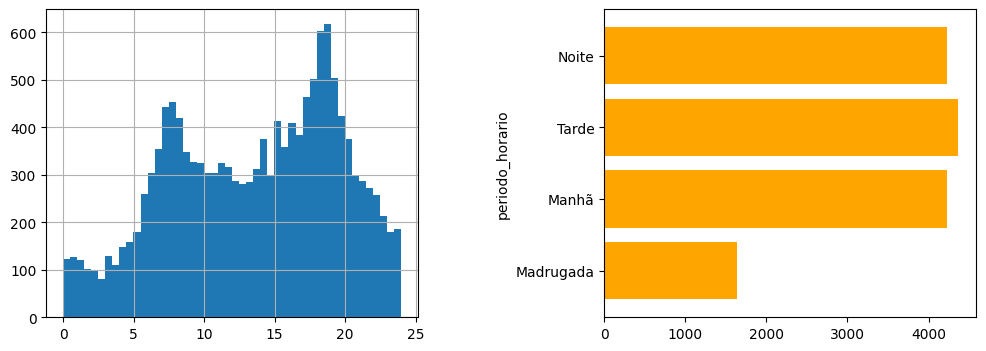

In [ ]:
# Distribuição horária e Período do Dia

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ocorrencias.hora.hist(bins=48, ax=axs[0])
ocorrencias.groupby('periodo_horario').size().reindex(['Madrugada','Manhã','Tarde','Noite']).plot(kind='barh', width=0.8, ax=axs[1], color='orange')
plt.subplots_adjust(wspace=0.5) # distância entre subplots
plt.show()


Nota-se menor incidência de acidentes durante a madrugada. Ao longo do dia, há pico de acidentes em torno das 17h e 18h.

### Radares

Vamos verificar quais são os **principais tipos de acidentes** que ocorrem nas proximidades de **radares** `['radar_500m' >= 1]`, e fora delas `['radar_500m' == 0]`.

As visualizações serão mediante tabelas e gráficos pizza.

In [ ]:
# Tipos de acidentes em proximidades de radares (500m)
tipo_radares = ocorrencias[ocorrencias['radar_500m'] >= 1].groupby('tipo_acidente').agg({
    'mortos': 'sum',             # Soma de mortos
    'feridos_graves': 'sum',     # Soma de feridos graves
    'uf': 'count'                # Contagem de ocorrências (acidentes)
})
tipo_radares.rename(columns={'uf': 'acidentes'}, inplace=True)

# Top10 tipos de acidentes
tipo_radares.nlargest(10, 'acidentes')

,mortos,feridos_graves,acidentes
tipo_acidente,,,
Colisão traseira,15,148,640
Colisão transversal,9,159,431
Colisão lateral mesmo sentido,5,80,378
Atropelamento de Pedestre,29,112,197
Tombamento,8,50,157
Colisão frontal,22,57,141
Saída de leito carroçável,10,23,114
Queda de ocupante de veículo,2,40,106
Colisão com objeto,6,23,103


In [ ]:
# Tipos de acidentes fora das proximidades de radares (500m)
tipo_geral = ocorrencias[ocorrencias['radar_500m'] == 0].groupby('tipo_acidente').agg({
    'mortos': 'sum',             # Soma de mortos
    'feridos_graves': 'sum',     # Soma de feridos graves
    'uf': 'count'                # Contagem de ocorrências (acidentes)
})
tipo_geral.rename(columns={'uf': 'acidentes'}, inplace=True)

# Top10 tipos de acidentes
tipo_geral.nlargest(10, 'acidentes')

,mortos,feridos_graves,acidentes
tipo_acidente,,,
Colisão traseira,156,693,2248
Saída de leito carroçável,161,461,1641
Colisão transversal,136,657,1506
Colisão frontal,578,869,1250
Colisão lateral mesmo sentido,43,264,1008
Tombamento,76,257,947
Colisão com objeto,57,187,663
Atropelamento de Pedestre,221,360,650
Queda de ocupante de veículo,31,181,545


In [ ]:
# Visualizações (Gráficos pizza): Top 7

# Preparando os dados
top_geral = tipo_geral.nlargest(7, 'acidentes')
qtd_outros = tipo_geral[['mortos','feridos_graves','acidentes']].sum() - top_geral[['mortos','feridos_graves','acidentes']].sum()
top_geral = pd.concat([top_geral, pd.DataFrame({'mortos': qtd_outros[0], 'feridos_graves':qtd_outros[1], 'acidentes': qtd_outros[2]},
                                                 index=['Outros'])])

top_radares = tipo_radares.nlargest(7, 'acidentes')
qtd_outros = tipo_radares[['mortos','feridos_graves','acidentes']].sum() - top_radares[['mortos','feridos_graves','acidentes']].sum()
top_radares = pd.concat([top_radares, pd.DataFrame({'mortos': qtd_outros[0], 'feridos_graves':qtd_outros[1], 'acidentes': qtd_outros[2]},
                                                 index=['Outros'])])


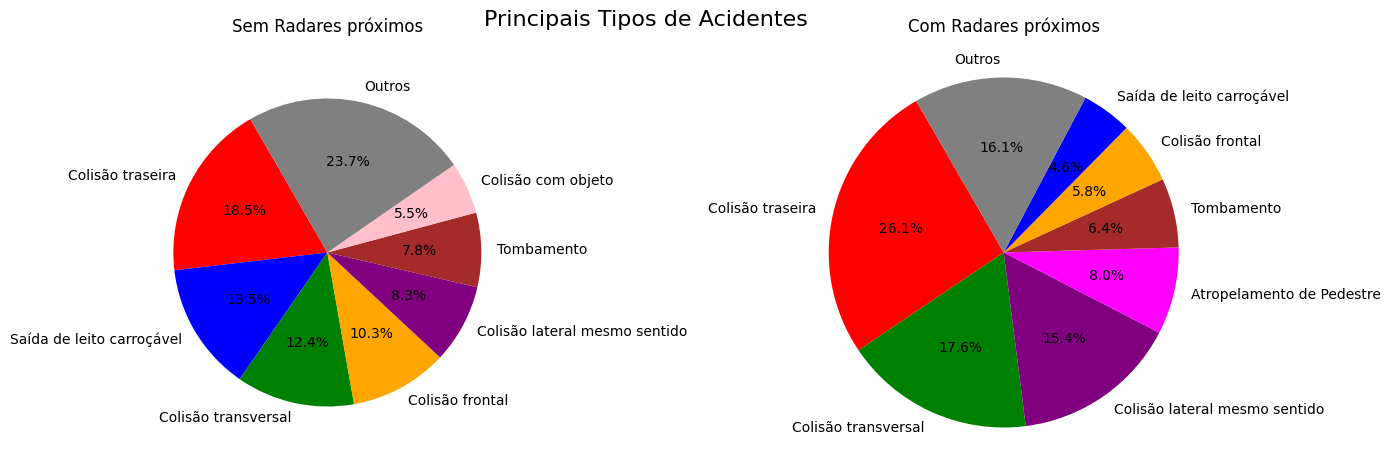

In [ ]:
# Cores para o pizza
cores_acidente = {
    'Colisão traseira': 'red',
    'Saída de leito carroçável': 'blue',
    'Colisão transversal': 'green',
    'Colisão frontal': 'orange',
    'Colisão lateral mesmo sentido': 'purple',
    'Tombamento': 'brown',
    'Colisão com objeto': 'pink',
    'Atropelamento de Pedestre': 'magenta',
    'Queda de ocupante de veículo': 'cyan',
    'Colisão lateral sentido oposto': 'yellow',
    'Outros': 'gray'
}
top_radares['cores'] = top_radares.index.map(cores_acidente)
top_geral['cores'] = top_geral.index.map(cores_acidente)

# Plotando o gráfico
fig, axs = plt.subplots(1,2, figsize=(16,5))
top_geral['acidentes'].plot(kind='pie',  autopct='%1.1f%%',
                      subplots=True, ax=axs[0], ylabel='', startangle=120, title='Sem Radar', colors=top_geral['cores'])
top_radares['acidentes'].plot(kind='pie',  autopct='%1.1f%%',
                      subplots=True, ax=axs[1], ylabel='', startangle=120, title='Principais tipos de Acidentes', colors=top_radares['cores'])
plt.axis('equal')  # Para garantir que o gráfico de pizza seja exibido como um círculo
axs[0].set_title('Sem Radares próximos', pad=20)
axs[1].set_title('Com Radares próximos', pad=20)
fig.suptitle('Principais Tipos de Acidentes', fontsize=16)
plt.show()

Como se vê, há diferenças entre os principais tipos de acidentes registrados nas proximidades de radares e fora delas.

Nota-se que "Saída de leito carroçavel", o 2º princial tipo de acidente em áreas sem radar, cai para a 7ª posição em trechos com radares próximos, com apenas 4.6% das ocorrências.

Isso pode ser indicativo de que a velocidade empreendida em trechos sem radar são superiores aos trechos controlados, facilitando a perda de controle da direção do veículo.

Outra observação é que 'Atropelamento de pedestre' é o 4ª principal tipo de acidente em proximidades de radares, enquanto não aparece nesse ranking das áreas 'sem radar'.

Uma possível explicação é que os equipamentos costumam existir em trechos urbanos, onde há maior trânsito de pedestre.

## Bivariadas

### Geolocalização

Através de scatterplot com base nos dados de latitute e longitude, visusualizaremos a geolocalização dos acidentes.

No gráfico utilizaremos ainda uma escala de cor para indicar a quantidade de pessoas envolvidas em cada acidente plotado.

<Axes: xlabel='longitude', ylabel='latitude'>

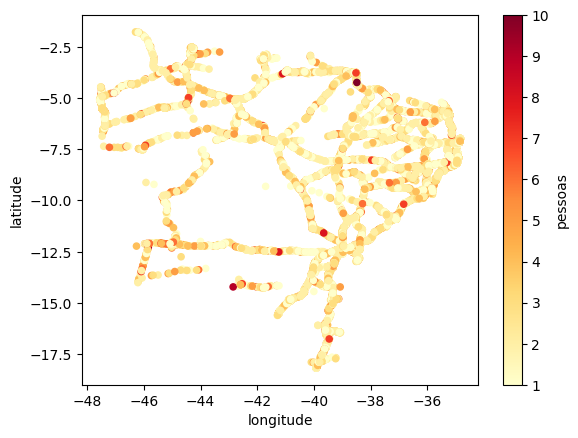

In [ ]:
# Geolocalização - scattermap com indicação de quantidade de pessoas envolvidas
ocorrencias.plot(x="longitude", y="latitude", kind="scatter", c="pessoas",
        colormap="YlOrRd")

### Correlações e Covariância

Vamos observar as correlações de Person e de Spearman para os atributos do dataset, assim como as covariâncias.

A correlação de Pearson mede a força e a direção da relação linear entre duas variáveis, com valores padronizados entre -1 a 1.

A correlação de Spearman mede a força e a direção da relação monotônica (não necessariamente linear) entre duas variáveis, com valores padronizados entre -1 a 1.

A covariância mede a direção da relação linear entre duas variáveis, mas não a força. Não é padronizada e pode variar de -∞ a +∞.

In [ ]:
# Correlações (Person)
ocorrencias_code.corr(method='pearson')

,data_hora,ano,mes,dia,hora,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,radar_500m,radar_1km,radar_5km
data_hora,1.000000,NaN,0.996527,0.082973,0.013577,0.014732,0.003887,0.002677,0.001089,-0.006098,0.005878,-0.015607,-0.005758,0.003857,-0.007060,-0.025522,0.017007,0.023043,0.000065,0.000818,0.004944,-0.012574,0.012953,0.003976,0.027481,0.001668,-0.010529,0.006882,0.006776,-0.007121,-0.008198,0.002933,-0.004855
ano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mes,0.996527,NaN,1.000000,-0.000018,0.011732,0.013457,0.002985,0.002065,0.001384,-0.006454,0.006768,-0.015064,-0.005324,0.004343,-0.006319,-0.026828,0.017858,0.023117,0.000408,0.000922,0.004602,-0.013171,0.013294,0.004178,0.028082,0.000538,-0.010888,0.006031,0.007093,-0.006500,-0.008716,0.002840,-0.005494
dia,0.082973,NaN,-0.000018,1.000000,-0.006321,0.016678,0.010564,0.006400,-0.003732,0.004926,-0.009268,-0.005848,-0.004715,-0.002863,-0.008025,0.017617,-0.010788,-0.002032,-0.005260,-0.003924,0.004883,0.005463,-0.005222,-0.003584,-0.006997,0.013162,0.003918,0.010235,-0.005031,-0.008250,0.006848,0.001745,0.007286
hora,0.013577,NaN,0.011732,-0.006321,1.000000,0.003517,0.009072,0.019061,-0.005868,-0.004501,0.019187,-0.078681,-0.033346,-0.133356,-0.017706,-0.058630,0.042333,0.043299,0.029939,0.017116,0.012774,-0.021498,0.040472,0.000685,0.055295,0.012486,-0.027574,0.011540,0.038893,0.028013,0.011014,0.014678,0.014366
dia_semana,0.014732,NaN,0.013457,0.016678,0.003517,1.000000,0.007256,-0.026192,0.005804,0.007677,-0.015961,-0.007341,0.014328,0.045097,-0.000095,0.006226,-0.019817,0.012634,0.027405,-0.000851,-0.019035,-0.006301,-0.016762,0.026245,0.027478,0.005816,0.000637,0.004629,-0.015320,-0.012141,0.026784,0.028738,0.026947
uf,0.003887,NaN,0.002985,0.010564,0.009072,0.007256,1.000000,0.097463,-0.420316,0.042923,-0.073923,-0.049047,0.032815,0.000676,0.000026,-0.004107,-0.176224,0.062716,0.143147,-0.038220,-0.061387,-0.009305,-0.002402,-0.027445,0.018175,0.468291,0.262214,0.975700,-0.120958,-0.160901,0.158502,0.184489,0.232117
br,0.002677,NaN,0.002065,0.006400,0.019061,-0.026192,0.097463,1.000000,-0.024114,0.038027,-0.007537,-0.044546,-0.008963,-0.044592,-0.000317,-0.009302,0.157524,0.047994,-0.034844,-0.008682,0.016815,-0.014454,0.017641,-0.025805,-0.015083,0.002682,-0.112223,0.096337,0.211322,-0.015094,-0.123545,-0.144361,-0.235833
km,0.001089,NaN,0.001384,-0.003732,-0.005868,0.005804,-0.420316,-0.024114,1.000000,0.006219,0.058533,0.051588,-0.051870,-0.016708,-0.005367,0.004298,0.263536,-0.062881,-0.172522,0.024982,0.070295,0.015936,0.002276,0.009625,-0.044262,-0.526977,-0.382357,-0.435279,0.347080,0.136259,-0.177014,-0.216436,-0.307975
municipio,-0.006098,NaN,-0.006454,0.004926,-0.004501,0.007677,0.042923,0.038027,0.006219,1.000000,-0.012073,0.003420,0.011102,0.016834,-0.006773,0.008212,-0.052121,0.007868,0.035345,-0.025607,-0.017591,0.005568,-0.025593,-0.013126,-0.004319,-0.053129,-0.004503,0.044824,0.050064,-0.126897,0.059924,0.071292,0.096316


In [ ]:
correlacoes = ocorrencias_code.corr(method='pearson')

# Encontrar as maiores correlações
maiores_correlacoes = correlacoes.unstack().sort_values(ascending=False)

# Remover as correlações iguais a 1 (correlação perfeita de uma variável consigo mesma)
maiores_correlacoes = maiores_correlacoes[maiores_correlacoes != 1]

# Exibir as maiores correlações
print(maiores_correlacoes.head(20))

data_hora        mes                0.996538
mes              data_hora          0.996538
uf               regional           0.975808
regional         uf                 0.975808
periodo_horario  hora               0.956048
hora             periodo_horario    0.956048
km               trecho_br          0.768400
trecho_br        km                 0.768400
ilesos           pessoas            0.761280
pessoas          ilesos             0.761280
delegacia        tipo_pista         0.528464
tipo_pista       delegacia          0.528464
uf               latitude           0.469859
latitude         uf                 0.469859
                 regional           0.456551
regional         latitude           0.456551
feridos_leves    pessoas            0.448417
pessoas          feridos_leves      0.448417
veiculos         pessoas            0.425636
pessoas          veiculos           0.425636
dtype: float64


In [ ]:
# Correlações (Spearman)
ocorrencias_code.corr(method='spearman')

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
data_hora,1.000000,NaN,0.996432,0.085770,0.015862,0.016805,0.013030,0.004591,0.005829,-0.002630,-0.007672,0.004895,-0.012209,-0.006366,-0.003715,-0.007251,-0.003108,0.015995,0.028949,-0.000700,0.002453,0.000887,-0.008355,0.014487,0.007910,0.022276,0.005333,-0.006165,0.007180,0.007689,-0.006517,-0.005335
ano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mes,0.996432,NaN,1.000000,0.001952,0.013661,0.014892,0.012002,0.003673,0.004468,-0.002482,-0.008001,0.005720,-0.011428,-0.005815,-0.002831,-0.006237,-0.003837,0.016572,0.028691,-0.000134,0.002808,0.000450,-0.008976,0.014834,0.008474,0.022840,0.004148,-0.005958,0.006327,0.007734,-0.006157,-0.004561
dia,0.085770,NaN,0.001952,1.000000,-0.006230,-0.008240,0.017073,0.011026,0.014040,-0.003428,0.004332,-0.009152,-0.006869,-0.006016,0.000202,-0.010316,0.009156,-0.008848,0.002968,-0.006384,-0.004982,0.004314,0.007619,-0.005715,-0.005769,-0.005686,0.012834,-0.001147,0.010624,-0.001604,-0.005416,-0.010502
hora,0.015862,NaN,0.013661,-0.006230,1.000000,0.959830,0.000327,0.012752,0.020119,0.001753,-0.008385,0.009663,-0.084027,-0.036119,-0.351377,-0.019402,-0.049055,0.050059,0.029501,0.025349,0.021777,0.022038,-0.035785,0.049840,-0.011155,0.059740,0.020079,-0.031670,0.015445,0.045567,0.033813,-0.002101
periodo_horario,0.016805,NaN,0.014892,-0.008240,0.959830,1.000000,0.003084,0.011724,0.020435,0.001962,-0.006921,0.011514,-0.088851,-0.039187,-0.331217,-0.016429,-0.051085,0.048542,0.032621,0.025037,0.022564,0.020082,-0.032623,0.051018,-0.011766,0.063315,0.016878,-0.027303,0.014193,0.043849,0.034922,-0.002361
dia_semana,0.013030,NaN,0.012002,0.017073,0.000327,0.003084,1.000000,0.010138,-0.021112,0.000030,0.006520,-0.012119,-0.002476,0.015628,0.048826,-0.000513,0.008449,-0.019948,0.006104,0.027028,0.005027,-0.019517,-0.002097,-0.014930,0.030745,0.027002,0.009496,0.004447,0.007594,-0.014239,-0.012156,0.010084
uf,0.004591,NaN,0.003673,0.011026,0.012752,0.011724,0.010138,1.000000,0.078947,-0.340498,0.037518,-0.073875,-0.039762,0.030947,-0.008727,-0.001762,-0.007818,-0.176307,0.061104,0.151737,-0.024768,-0.053099,-0.006236,0.009803,-0.025401,0.027366,0.467754,0.300812,0.976265,-0.005477,-0.105941,-0.243643
br,0.005829,NaN,0.004468,0.014040,0.020119,0.020435,-0.021112,0.078947,1.000000,0.025534,0.037130,-0.013718,-0.040698,-0.008047,-0.048532,0.006456,0.008472,0.148584,0.042873,-0.014835,-0.003646,0.020174,-0.017793,0.022840,-0.025912,-0.008352,0.030049,-0.244195,0.078923,0.152732,-0.024707,0.023713
km,-0.002630,NaN,-0.002482,-0.003428,0.001753,0.001962,0.000030,-0.340498,0.025534,1.000000,-0.015669,0.046938,0.024243,-0.054703,-0.013974,-0.007222,-0.007795,0.312780,-0.062094,-0.213067,0.014329,0.081465,-0.009919,0.009533,0.005254,-0.055962,-0.388266,-0.395156,-0.364113,0.304844,0.134573,0.859365


In [136]:
correlacoes = ocorrencias_code.corr(method='spearman')

# Encontrar as maiores correlações
maiores_correlacoes = correlacoes.unstack().sort_values(ascending=False)

# Remover as correlações iguais a 1 (correlação perfeita de uma variável consigo mesma)
maiores_correlacoes = maiores_correlacoes[maiores_correlacoes != 1]

# Exibir as maiores correlações
print(maiores_correlacoes.head(20))

data_hora        mes                0.996431
mes              data_hora          0.996431
uf               regional           0.976145
regional         uf                 0.976145
periodo_horario  hora               0.959739
hora             periodo_horario    0.959739
trecho_br        km                 0.860063
km               trecho_br          0.860063
pessoas          veiculos           0.671794
veiculos         pessoas            0.671794
delegacia        tipo_pista         0.541577
tipo_pista       delegacia          0.541577
ilesos           pessoas            0.536644
pessoas          ilesos             0.536644
ilesos           veiculos           0.514386
veiculos         ilesos             0.514386
uf               latitude           0.463641
latitude         uf                 0.463641
                 regional           0.447874
regional         latitude           0.447874
dtype: float64


In [ ]:
ocorrencias_code.cov()

,data_hora,ano,mes,dia,hora,periodo_horario,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,veiculos,latitude,longitude,regional,delegacia,uop,trecho_br
data_hora,8.291695e+13,0.0,3.131132e+07,6.790624e+06,806974.807844,148643.516980,249907.699903,89548.188853,121480.249145,-1.953397e+06,-1.256826e+07,1.474431e+06,-624327.159140,-26838.713627,25791.349397,-32141.948154,-345303.089058,144055.302550,1.097974e+07,-2735.416429,66565.913674,19633.374811,-138597.673592,77023.529049,133848.128862,153727.499254,108719.595658,-306152.106618,147446.179456,696192.709550,-1.957194e+06,-5.261667e+06
ano,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
mes,3.131132e+07,0.0,1.190615e+01,6.799685e-02,0.268920,0.051083,0.085648,0.027256,0.026897,-4.925708e-01,-4.947553e+00,6.279042e-01,-0.227061,-0.009235,0.011238,-0.010577,-0.136850,0.056935,4.176788e+00,-0.000295,0.025669,0.006796,-0.055192,0.029289,0.053133,0.059261,0.028007,-0.118867,0.049689,0.273438,-6.854653e-01,-1.708335e+00
dia,6.790624e+06,0.0,6.799685e-02,7.679443e+01,-0.359994,-0.074075,0.300834,0.198131,0.510908,-8.063910e+00,6.888397e+00,-1.795676e+00,-0.263482,-0.026522,-0.025047,-0.045298,0.203806,-0.076503,-1.057228e+00,-0.027917,-0.043655,0.022519,0.060051,-0.009447,-0.077134,-0.029862,0.393626,0.073247,0.189112,-0.432066,-1.909236e+00,-9.317603e+00
hora,8.069748e+05,0.0,2.689197e-01,-3.599935e-01,35.331155,5.649677,0.038772,0.141370,0.904642,-8.594275e+00,-7.315851e+00,2.619184e+00,-2.008700,-0.097249,-0.600710,-0.051257,-0.474787,0.232112,1.335557e+01,0.087780,-0.006525,0.023403,-0.158144,0.151777,-0.073425,0.203469,0.293701,-0.510143,0.174128,2.928277,5.064532e+00,-1.674045e+00
periodo_horario,1.486435e+05,0.0,5.108314e-02,-7.407534e-02,5.649677,0.988395,0.013601,0.023896,0.173156,-1.618906e+00,-9.684195e-01,4.618700e-01,-0.369854,-0.017170,-0.080916,-0.007412,-0.086664,0.038167,2.446779e+00,0.015630,-0.009534,0.003128,-0.027356,0.025094,-0.018866,0.034470,0.042574,-0.075288,0.028554,0.480941,8.212026e-01,-3.443076e-01
dia_semana,2.499077e+05,0.0,8.564833e-02,3.008344e-01,0.038772,0.013601,4.050743,0.041565,-0.417603,1.486159e+00,2.389092e+00,-7.641256e-01,-0.063551,0.016639,0.072025,-0.000172,0.025887,-0.037520,1.270285e+00,0.027898,-0.050641,-0.015866,-0.008088,-0.022560,0.005960,0.037251,0.049115,0.013889,0.030110,-0.426066,-7.766156e-01,2.317494e+00
uf,8.954819e+04,0.0,2.725650e-02,1.981310e-01,0.141370,0.023896,0.041565,5.256047,1.920697,-2.177180e+02,1.833629e+01,-4.070542e+00,-0.477093,0.039513,0.001314,-0.001474,-0.026072,-0.379952,7.500911e+00,0.163922,-0.206424,-0.052611,-0.047887,-0.005924,-0.132239,0.020817,3.733605,1.944780,5.137337,-3.767967,-1.126710e+01,-4.966918e+01
br,1.214802e+05,0.0,2.689691e-02,5.109084e-01,0.904642,0.173156,-0.417603,1.920697,73.896159,-4.886273e+01,5.976494e+01,-1.138092e+00,-1.709608,-0.042888,-0.291136,0.004078,-0.109306,1.260923,2.082814e+01,-0.154411,-0.075664,0.055946,-0.059020,0.096288,-0.263132,-0.060957,0.105719,-3.009984,1.906304,23.936067,-4.244868e+00,3.800912e+00
km,-1.953397e+06,0.0,-4.925708e-01,-8.063910e+00,-8.594275,-1.618906,1.486159,-217.717955,-48.862727,5.082320e+04,1.745047e+02,3.176405e+02,49.843210,-6.065209,-2.935554,-0.278828,1.678117,55.606725,-7.350965e+02,-19.250098,16.438215,5.930402,5.705493,0.773751,8.492022,-5.783606,-411.567497,-277.032339,-225.777884,1047.036559,9.370473e+02,1.736776e+04


In [138]:
covariancia = ocorrencias_code.cov()

# Encontrar as maiores correlações
maiores_cov = covariancia.unstack().sort_values(ascending=False)

# Remover as correlações iguais a 1 (correlação perfeita de uma variável consigo mesma)
maiores_cov = maiores_cov[maiores_cov != 0]

# Exibir as maiores correlações
print(maiores_cov.head(20))

data_hora       data_hora         8.271774e+13
                mes               3.124051e+07
mes             data_hora         3.124051e+07
data_hora       tracado_via       1.079288e+07
tracado_via     data_hora         1.079288e+07
dia             data_hora         6.633282e+06
data_hora       dia               6.633282e+06
km              data_hora         1.954566e+06
data_hora       km                1.954566e+06
                causa_acidente    1.319759e+06
causa_acidente  data_hora         1.319759e+06
delegacia       data_hora         8.263271e+05
data_hora       delegacia         8.263271e+05
hora            data_hora         7.257699e+05
data_hora       hora              7.257699e+05
dia_semana      data_hora         2.600727e+05
data_hora       dia_semana        2.600727e+05
br              data_hora         2.164599e+05
data_hora       br                2.164599e+05
                veiculos          1.583123e+05
dtype: float64


### Relacionamentos entre métricas

Vamos analisar **relacionamentos entre algumas métricas dos acidentes**, como quantidade de veículos e quantidade de pessoas envolvidas, ou quantidade de lesionados graves e quantidade de radares nas proximidades.

Como se tratam de atributos discretos, utilizaremos gráficos de bolha, uma variação do gráfico de dispersão em que os pontos são representados por bolhas ou círculos, com tamannho proporcional à contagem dos acidentes.

#### Veículos X Pessoas, Feridos ou Mortos

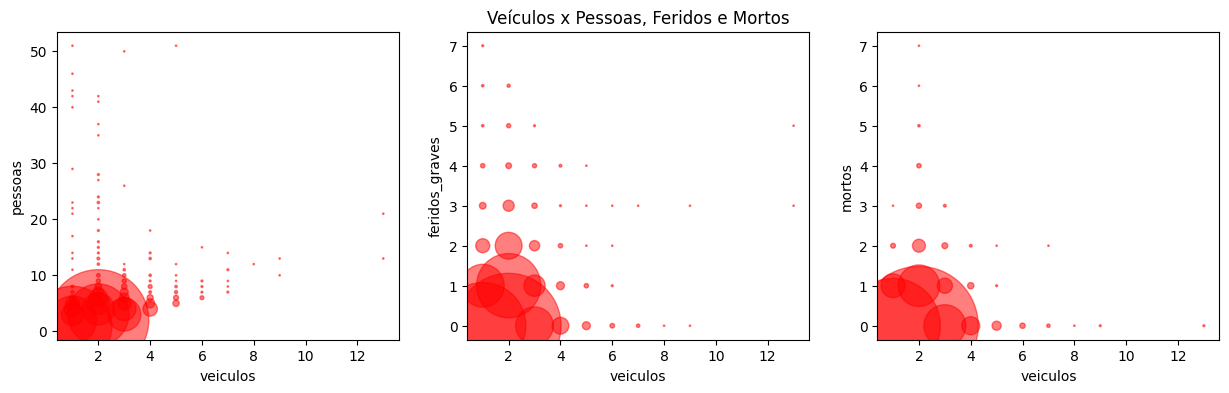

In [ ]:
# Relacionamentos entre veículos e pessoas, feridos ou mortos
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
veic_pessoas = ocorrencias.groupby(['veiculos', 'pessoas']).size().reset_index(name='qtd')
veic_feridos = ocorrencias.groupby(['veiculos', 'feridos_graves']).size().reset_index(name='qtd')
veic_mortos = ocorrencias.groupby(['veiculos', 'mortos']).size().reset_index(name='qtd')
veic_pessoas.plot.scatter(x='veiculos', y='pessoas', s=veic_pessoas['qtd'], alpha=0.5, color='red', ax=axs[0])
veic_feridos.plot.scatter(x='veiculos', y='feridos_graves', s=veic_feridos['qtd'], alpha=0.5, color='red', ax=axs[1], title="Veículos x Pessoas, Feridos e Mortos")
veic_mortos.plot.scatter(x='veiculos', y='mortos', s=veic_mortos['qtd'], alpha=0.5, color='red', ax=axs[2])
plt.show()

>

Pelas dispersões acima, nota-se que uma maior quantidade de veículos tende a indicar uma maior quantidade de pessoas envolvidas no acidente, como seria de se esperar.

Contudo, a quantidade de mortos não se comporta da mesma maneira.

No gráfico abaixo, vemos os principais tipos de acidentes que envolvem 4 ou mais veículos:



<Axes: ylabel='tipo_acidente'>

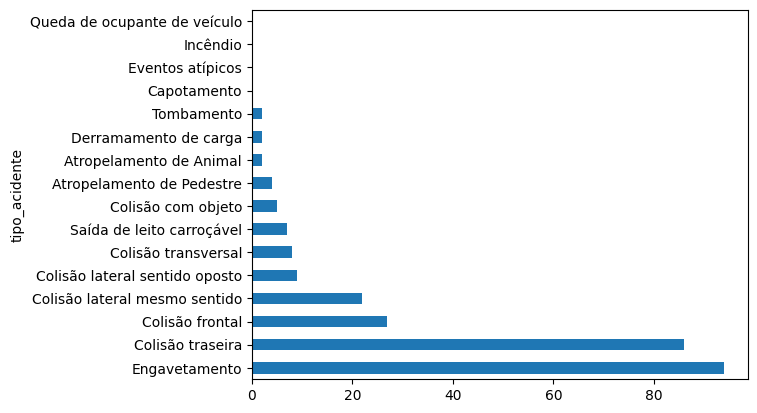

In [ ]:
# Tipos de acidentes para ocorrências com 4 ou mais veículos
ocorrencias[ocorrencias.veiculos >= 4].groupby('tipo_acidente').size().sort_values(ascending=False).plot(kind='barh')

#### Radares X Feridos ou Mortos

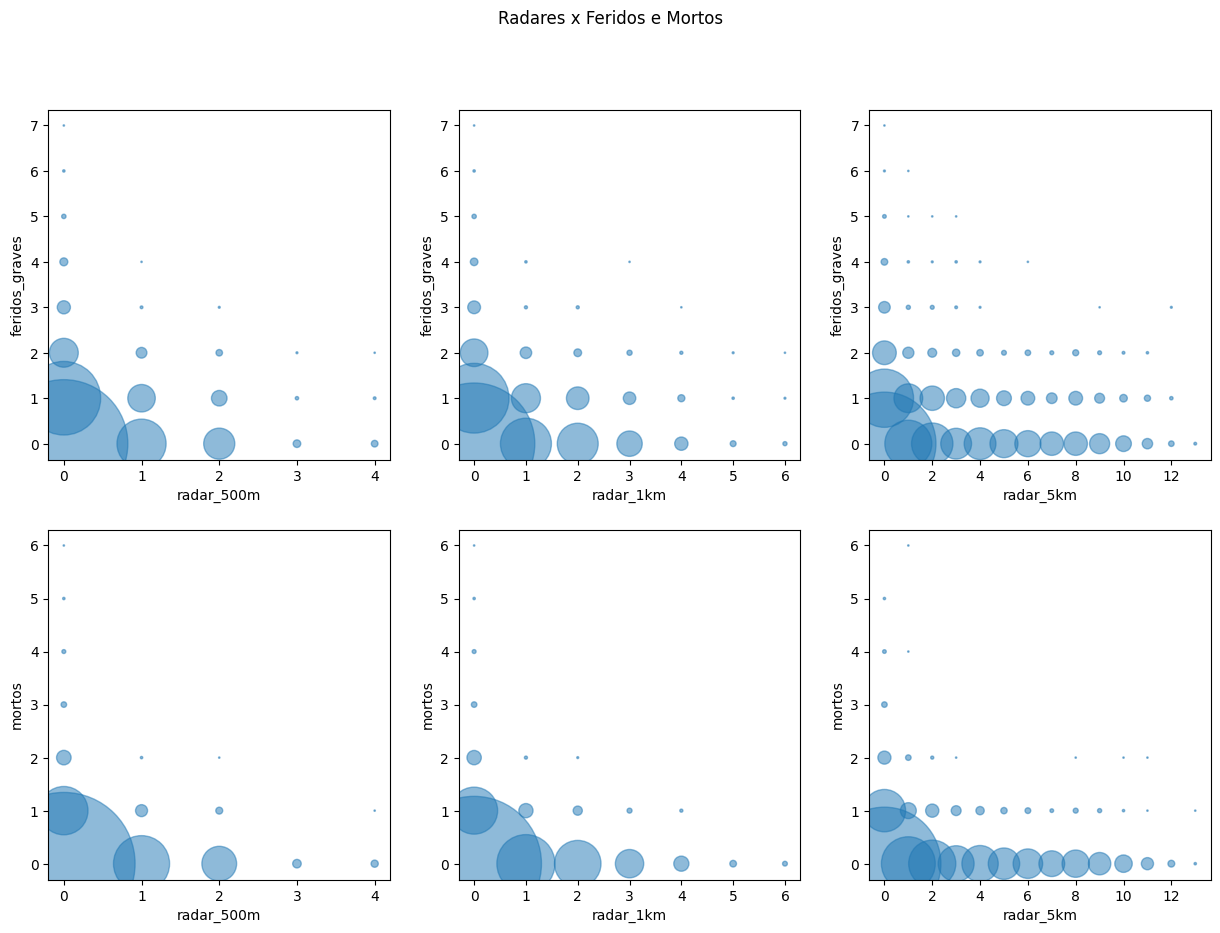

In [ ]:
# Relacionamentos entre radares e feridos ou mortos

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
feridos_radar500 = ocorrencias.groupby(['radar_500m', 'feridos_graves']).size().reset_index(name='qtd')
feridos_radar1k = ocorrencias.groupby(['radar_1km', 'feridos_graves']).size().reset_index(name='qtd')
feridos_radar5k = ocorrencias.groupby(['radar_5km', 'feridos_graves']).size().reset_index(name='qtd')
mortos_radar500 = ocorrencias.groupby(['radar_500m', 'mortos']).size().reset_index(name='qtd')
mortos_radar1k = ocorrencias.groupby(['radar_1km', 'mortos']).size().reset_index(name='qtd')
mortos_radar5k = ocorrencias.groupby(['radar_5km', 'mortos']).size().reset_index(name='qtd')

feridos_radar500.plot.scatter(y='feridos_graves', x='radar_500m', ax=axs[0][0], subplots=True, s=feridos_radar500['qtd'], alpha=0.5, title="Radares x Feridos e Mortos")
feridos_radar1k.plot.scatter(y='feridos_graves', x='radar_1km', ax=axs[0][1], subplots=True, s=feridos_radar1k['qtd'], alpha=0.5)
feridos_radar5k.plot.scatter(y='feridos_graves', x='radar_5km', ax=axs[0][2], subplots=True, s=feridos_radar5k['qtd'], alpha=0.5)
mortos_radar500.plot.scatter(y='mortos', x='radar_500m', ax=axs[1][0], subplots=True, s=mortos_radar500['qtd'], alpha=0.5)
mortos_radar1k.plot.scatter(y='mortos', x='radar_1km', ax=axs[1][1], subplots=True, s=mortos_radar1k['qtd'], alpha=0.5)
mortos_radar5k.plot.scatter(y='mortos', x='radar_5km', ax=axs[1][2], subplots=True, s=mortos_radar5k['qtd'], alpha=0.5)

plt.show()

Pelas dispersões, vemos que as ocorrências com maior número de feridos graves e mortos ocorrem em trechos sem radar, o que pode refletir eventos de maior gravidade pelo possível excesso de velocidade.

Contudo, a maior parte das ocorrências apresenta entre 0 e 2 pessoas mortas ou feridas graves.

# TESTES DE HIPÓTESES

## Distribuição horária dos acidentes em Pernambuco

> H0: PE == Restante

> H1: PE != Restante

> Valor crítico: 5%

Como a são grupos não pareados, e sem distribuição normal, vamos utilizar o método Mann Whitney U.

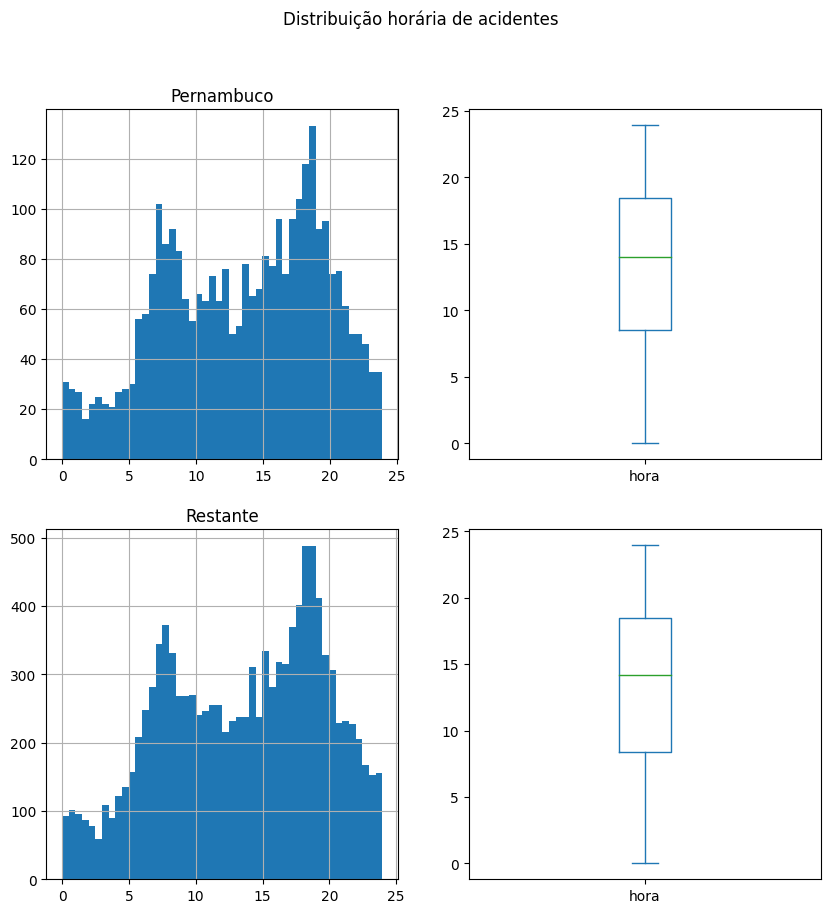

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
ocorrencias[ocorrencias.uf == 'PE']['hora'].hist(bins=48, ax=axs[0][0])
ocorrencias[ocorrencias.uf == 'PE']['hora'].plot.box(ax=axs[0][1])
ocorrencias[ocorrencias.uf != 'PE']['hora'].hist(bins=48, ax=axs[1][0])
ocorrencias[ocorrencias.uf != 'PE']['hora'].plot.box(ax=axs[1][1])
axs[0][0].set_title('Pernambuco')
axs[1][0].set_title('Restante')
plt.suptitle("Distribuição horária de acidentes")
plt.show()

In [ ]:
# Não é gaussiana
stats.shapiro((ocorrencias[ocorrencias.uf == 'PE'].hora))

ShapiroResult(statistic=0.9664583802223206, pvalue=7.444344160805021e-26)

In [ ]:
# Mann Whitney U
stats.mannwhitneyu(ocorrencias[ocorrencias.uf == 'PE'].hora, ocorrencias[ocorrencias.uf != 'PE'].hora)

MannwhitneyuResult(statistic=17346516.0, pvalue=0.9391392212447315)

**Resultado:**
> p-value > valor crítico

H0 não rejeitada. Ou seja, PE == Restante.

## Distribuição dos acidentes por km da BR-101 (PE vs RN)

> H0: PE == RN

> H1: PE != RN

> Valor crítico: 5%

Optamos por comparar essas duas UFs porque a rodovia selecionada tem extensão similar em ambos os estados.

Como são grupos não pareados, e sem distribuição normal, vamos utilizar o método Mann Whitney U.

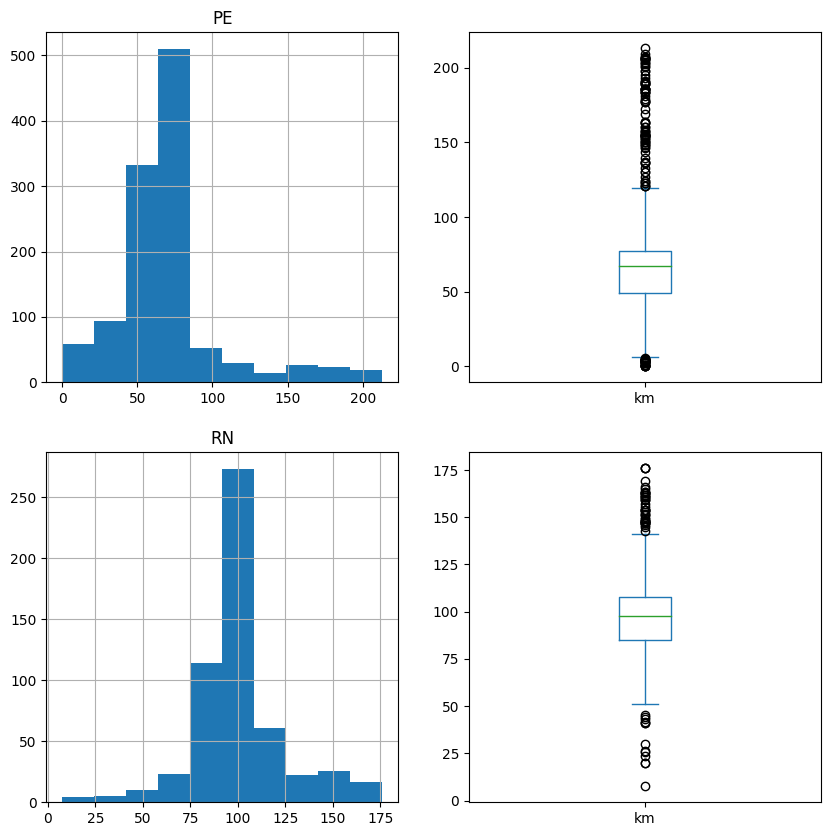

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
ocorrencias[(ocorrencias.uf == 'PE') & (ocorrencias.br == '101')]['km'].hist(ax=axs[0][0])
ocorrencias[(ocorrencias.uf == 'PE') & (ocorrencias.br == '101')]['km'].plot.box(ax=axs[0][1])
ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km'].hist(ax=axs[1][0])
ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km'].plot.box(ax=axs[1][1])
axs[0][0].set_title('PE')
axs[1][0].set_title('RN')
plt.show()

In [ ]:
# Checar se distribuições são gaussianas (shapiro)
print(stats.shapiro(ocorrencias[(ocorrencias.uf == 'PE') & (ocorrencias.br == '101')]['km']))
print(stats.shapiro(ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km']))

ShapiroResult(statistic=0.8317536115646362, pvalue=2.881004961763936e-33)
ShapiroResult(statistic=0.9322644472122192, pvalue=3.707080774756387e-15)


In [ ]:
# Mann Whitney U
stats.mannwhitneyu(ocorrencias[(ocorrencias.uf == 'PE') & (ocorrencias.br == '101')]['km'],
                   ocorrencias[(ocorrencias.uf == 'RN') & (ocorrencias.br == '101')]['km'])

MannwhitneyuResult(statistic=96896.0, pvalue=9.740154812032175e-122)

**Resultado:**
> p-value < valor crítico

H0 rejeitada. Ou seja, PE != RN.